In [1]:
####
#1 model version comparisons
import apache_beam

In [2]:
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm

In [3]:
#Observations
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
observations = xr.open_zarr(obs_path)
observations = observations['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')) #Same time?
observationsvals = observations.values
#6 Hour increments

In [4]:
#IFS ENS
forecast_path = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative.zarr'
forecast1 = xr.open_zarr(forecast_path)
forecast1
#12 Hour increments, pred 6 Hours #61

<xarray.Dataset>
Dimensions:                   (time: 3652, number: 50,
                               prediction_timedelta: 61, longitude: 64,
                               latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * number                    (number) int32 1 2 3 4 5 6 7 ... 45 46 47 48 49 50
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>

In [40]:
#IFS ENS mean
forecast2 = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr')
forecast2
#12 Hour increments, pred 6 Hours #61

<xarray.Dataset>
Dimensions:                   (time: 3652, prediction_timedelta: 61,
                               longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [41]:
#IFSHRES
forecast_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr'
forecast3 = xr.open_zarr(forecast_path)
forecast3
#12 Hour increments, pred 6 Hours #41

<xarray.Dataset>
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2016-01-01 ... 2022-12-31...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [42]:
#ERA 5 forecast
forecast4 = xr.open_zarr('gs://weatherbench2/datasets/era5-forecasts/2020-64x32_equiangular_conservative.zarr')
forecast4
#12 Hour increments, pred 6 Hours #31

<xarray.Dataset>
Dimensions:                  (time: 732, prediction_timedelta: 31,
                              longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int32 500 700 850
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 00:00:00 ...
  * time                     (time) datetime64[ns] 2020-01-01 ... 2020-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    vertical_velocity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [43]:
#Keisler GNN
forecast5 = xr.open_zarr('gs://weatherbench2/datasets/keisler/2020-64x32_equiangular_conservative.zarr')
forecast5

#12 Hour increments, pred 6 Hours #41

<xarray.Dataset>
Dimensions:               (level: 3, time: 732, prediction_timedelta: 41,
                           longitude: 64, latitude: 32)
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                 (level) int64 500 700 850
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-12-31T12:...
Data variables:
    geopotential          (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    specific_humidity     (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    temperature           (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    u_component_of_wind   (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    v_component_of_wind   (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    wind_speed            (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>

In [9]:
#Pangu Weather
forecast6 = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_64x32_equiangular_conservative.zarr')
forecast6
#12 Hour increments, pred 6 Hours #40, no time = 0? Useable, just don't compute for time =0?
#When finding MSE at all lags could just not find for that specific lag
#When comparing paths,  

<xarray.Dataset>
Dimensions:                  (time: 3652, prediction_timedelta: 40,
                              longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int64 1000 925 850 700 ... 200 150 100 50
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 06:00:00 ...
  * time                     (time) datetime64[ns] 2018-01-01 ... 2022-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [10]:
#Pangu Weather operational
forecast7 = xr.open_zarr('gs://weatherbench2/datasets/pangu_hres_init/2020_0012_64x32_equiangular_conservative.zarr')
forecast7
#12 Hour increments, pred 6 Hours #40, no time = 0 for pangu

<xarray.Dataset>
Dimensions:                  (time: 732, prediction_timedelta: 40,
                              longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int64 1000 925 850 700 ... 200 150 100 50
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 06:00:00 ...
  * time                     (time) datetime64[ns] 2020-01-01 ... 2020-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [11]:
#Graphcast
forecast8 = xr.open_zarr('gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')
forecast8

#12 Hour increments, pred 6 Hours #40, no 0 time

<xarray.Dataset>
Dimensions:                   (time: 886, prediction_timedelta: 40,
                               longitude: 64, latitude: 32, level: 37)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int64 1 2 3 5 7 ... 900 925 950 975 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 06:00:00...
  * time                      (time) datetime64[ns] 2019-11-16 ... 2021-01-31...
Data variables: (12/14)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>

In [12]:
#Graphcast operational
forecast9 = xr.open_zarr('gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')
forecast9

#12 Hour increments, pred 6 Hours #40, no 0 time

<xarray.Dataset>
Dimensions:                   (time: 732, prediction_timedelta: 40,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 06:00:00...
  * time                      (time) datetime64[ns] 2020-01-01 ... 2020-12-31...
Data variables: (12/14)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [13]:
#Spherical CNN
forecast10 = xr.open_zarr('gs://weatherbench2/datasets/sphericalcnn/2020-64x32_equiangular_conservative.zarr')
forecast10
#2 Day increments, pred 6 Hours #40, no time 0

<xarray.Dataset>
Dimensions:               (time: 178, prediction_timedelta: 40, level: 13,
                           longitude: 64, latitude: 32)
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                 (level) int64 50 100 150 200 250 ... 700 850 925 1000
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days 06:00...
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-12-20
Data variables:
    geopotential          (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>
    specific_humidity     (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>
    temperature           (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>
    u_component_of_wind   (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind   (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>
    wind_speed            (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>

In [14]:
#Fuxi
forecast11 = xr.open_zarr('gs://weatherbench2/datasets/fuxi/2020-64x32_equiangular_conservative.zarr')
forecast11

#12 Hour increments, pred 6 Hours #60, no time 0

<xarray.Dataset>
Dimensions:                            (time: 702, prediction_timedelta: 60,
                                        longitude: 64, latitude: 32, level: 2)
Coordinates:
  * latitude                           (latitude) float64 -87.19 ... 87.19
  * level                              (level) int32 500 850
  * longitude                          (longitude) float64 0.0 5.625 ... 354.4
  * prediction_timedelta               (prediction_timedelta) timedelta64[ns] ...
  * time                               (time) datetime64[ns] 2020-01-01 ... 2...
Data variables:
    10m_u_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_wind_speed                     (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    2m_temperature                     (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    geopotential                       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    temperature                        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    total_precipitation_24hr_from_6hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    total_precipitation_6hr            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    u_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    v_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    wind_speed                         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>

In [15]:
#NeuralGCM
forecast12 = xr.open_zarr('gs://weatherbench2/datasets/neuralgcm_deterministic/2020-64x32_equiangular_conservative.zarr')
forecast12

#12 Hour increments, pred 12 Hours #31 so quivalent to #61 at 6 hours halved


<xarray.Dataset>
Dimensions:                              (time: 732, prediction_timedelta: 31,
                                          longitude: 64, latitude: 32, level: 37)
Coordinates:
  * latitude                             (latitude) float64 -87.19 ... 87.19
  * level                                (level) int64 1 2 3 5 ... 950 975 1000
  * longitude                            (longitude) float64 0.0 5.625 ... 354.4
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] ...
  * time                                 (time) datetime64[ns] 2020-01-01 ......
Data variables:
    P_minus_E_cumulative                 (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    wind_speed                           (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
Attributes:
    experiment_id:  67001173
    worker_id:      1

In [16]:
#NeuralGCM ensenmble 
forecast13 = xr.open_zarr('gs://weatherbench2/datasets/neuralgcm_ens/2020-64x32_equiangular_conservative.zarr')
forecast13

#12 Hour increments, pred 12 Hours #31 so quivalent to #61 at 6 hours halved


<xarray.Dataset>
Dimensions:                              (realization: 50, time: 732,
                                          prediction_timedelta: 32, level: 37,
                                          longitude: 64, latitude: 32)
Coordinates:
  * latitude                             (latitude) float64 -87.19 ... 87.19
  * level                                (level) int64 1 2 3 5 ... 950 975 1000
  * longitude                            (longitude) float64 0.0 5.625 ... 354.4
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] ...
  * realization                          (realization) int64 0 1 2 ... 47 48 49
  * time                                 (time) datetime64[ns] 2020-01-01 ......
Data variables:
    geopotential                         (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_cloud_ice_water_content     (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_cloud_liquid_water_content  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_humidity                    (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    temperature                          (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind                  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    v_component_of_wind                  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    wind_speed                           (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
Attributes:
    experiment_id:  73974210
    worker_id:      3

In [ ]:
allforecasts = [forecast1,forecast2,forecast3,forecast4,forecast5,forecast6,forecast7,forecast8,forecast9,forecast10,forecast11,forecast12,forecast13]
allforecasts = [val['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')) for val in allforecasts]


In [45]:
#First going over a specific place and weighting seperately with all models
forecast2vals = forecast2['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

In [ ]:
forecast2vals

(50, 61, 64, 32)

In [18]:
forecast1vals = forecast1['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

In [ ]:
#All models 

allforecasts[0][:,0,:,:,:]

<xarray.DataArray 'geopotential' (time: 50, prediction_timedelta: 61,
                                  longitude: 64, latitude: 32)>
dask.array<getitem, shape=(50, 61, 64, 32), dtype=float32, chunksize=(4, 1, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
    level                 int32 500
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
    number                int32 1
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-01-25T12:...
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [73]:
def findscale(obs,fors):
    maxvalue = np.array([obs.max(),fors.max()]).max()

    return maxvalue

In [61]:
latitude = forecast1['latitude'][:].values
delta = 2.8125
theta_upper = latitude + delta
theta_lower = latitude - delta

# Calculate weights based on the provided formula
weights = (np.sin(np.radians(theta_upper)) - np.sin(np.radians(theta_lower)))
weights /= weights.sum()
weights *= 32

weights

array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])

In [69]:
grid = np.ones((64,32))
print(grid*weights)
forecast1

[[0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]
 [0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]
 [0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]
 ...
 [0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]
 [0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]
 [0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]]


<xarray.Dataset>
Dimensions:                   (time: 3652, number: 50,
                               prediction_timedelta: 61, longitude: 64,
                               latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * number                    (number) int32 1 2 3 4 5 6 7 ... 45 46 47 48 49 50
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>

In [241]:
def pkweighted(observations,forcasts,k):
    #Find more notes on function in ReframingSigKernel.ipynb
    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        max = findscale(observations, forcasts)
        observations = observations/max
        forcasts = forcasts/max

        static_kernel = sigkernel.Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forcasts.shape[0]

        grid = np.zeros((64,32))
        cuda = torch.device('cuda') 
        for i in range(math.floor(time- 0.5*k)): #20
                for j in range(64):
                        print(j)
                        for l in range(32):
                            fors = forcasts[i,:,0:k+1,j,l]
                            obs = observations[2*i:2*i+k+1,j,l]
                            print(fors)
                            print(obs)

                            obs = np.expand_dims(obs, axis = 0)
                            
                            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                            llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                            X = torch.tensor(llfors, dtype=torch.double, device = cuda)
                            y = torch.tensor(llobs, dtype=torch.double, device = cuda)

                            val = signature_kernel.compute_scoring_rule(X,y).item()
                            grid[j,l] = val

        return (grid)

In [242]:
gridtest = pkweighted(observationsvals,forecast1vals,5)
#Very very slow, should be parallelisable 

0
[[0.84641755 0.84488285 0.8452613  0.84559417 0.8457747  0.8451149 ]
 [0.84675306 0.84509635 0.8451714  0.84559    0.84571505 0.84505826]
 [0.84626776 0.84453475 0.84467983 0.8449861  0.8449987  0.8445922 ]
 [0.8462428  0.8445725  0.84472924 0.8447878  0.84523225 0.8447487 ]
 [0.8466356  0.8448909  0.84498775 0.8451638  0.845465   0.8451324 ]
 [0.84645694 0.8447359  0.8450588  0.8454143  0.84577364 0.8453661 ]
 [0.8464511  0.8450723  0.84500575 0.84538585 0.8456763  0.84512246]
 [0.8465036  0.8447077  0.84460306 0.84458965 0.84490895 0.8444506 ]
 [0.84641236 0.84496075 0.84498787 0.8453247  0.845585   0.8450784 ]
 [0.8460439  0.8444018  0.84417415 0.8445818  0.84475434 0.8443196 ]
 [0.8464556  0.84478647 0.8448     0.845344   0.8456199  0.84497833]
 [0.84678036 0.8452313  0.8454505  0.84558934 0.8458571  0.845329  ]
 [0.8464677  0.8450103  0.8452865  0.84548175 0.8457233  0.8450148 ]
 [0.84665215 0.8450469  0.8452459  0.84548604 0.84564215 0.8453802 ]
 [0.8464538  0.8449217  0.844816

c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 50 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[[0.97501236 0.9733392  0.9752961  0.9754326  0.9770878  0.9760836 ]
 [0.97512406 0.97334623 0.975458   0.9757199  0.97740924 0.9767059 ]
 [0.97522706 0.9734481  0.97517395 0.97516894 0.9771131  0.9765102 ]
 [0.97528744 0.9733705  0.9751292  0.9753016  0.9769975  0.9761403 ]
 [0.97527957 0.9735333  0.9756996  0.97532946 0.97720045 0.9761634 ]
 [0.97504896 0.9736178  0.97532105 0.97530645 0.9770793  0.9763551 ]
 [0.9753082  0.97375757 0.9753989  0.9755116  0.9769394  0.976337  ]
 [0.97514826 0.9736174  0.97534364 0.9757047  0.9776903  0.97710264]
 [0.9751679  0.97351635 0.9752158  0.97538245 0.9772422  0.97663736]
 [0.97505975 0.97345734 0.97513646 0.9753859  0.9766021  0.97611463]
 [0.9751016  0.9733408  0.9751857  0.9756775  0.9776568  0.97674143]
 [0.97534066 0.9738314  0.9753351  0.9752893  0.97688514 0.97575676]
 [0.9754066  0.973782   0.975497   0.97529477 0.97700214 0.9756722 ]
 [0.9752386  0.9735727  0.9752964  0.97537726 0.9772032  0.9764955 ]
 [0.9750711  0.97328675 0.9751407 

KeyboardInterrupt: 

In [126]:
forecast1vals.shape

(50, 50, 61, 64, 32)

In [139]:
def pksoloweighted(observations,forcastsolo,k):
    #Find more notes on function in ReframingSigKernel.ipynb
    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        max = findscale(observations, forcastsolo)
        observations = observations/max
        forcastsolo = forcastsolo/max

        static_kernel = sigkernel.Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forcastsolo.shape[0]
        shiftedtime = math.floor(time- 0.5*k)
        print(shiftedtime)
        grid = np.zeros((shiftedtime, 64,32))

        for i in range(shiftedtime): #20
                print(i)
                for j in range(64):
                        for l in range(32):
                            fors = forcastsolo[i,0:k+1,j,l]
                            obs = observations[2*i:2*i+k+1,j,l]

                            fors = np.expand_dims(fors, axis = 0)
                            obs = np.expand_dims(obs, axis = 0)
                            
                            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                            llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                            X = torch.tensor(llfors, dtype=torch.double)
                            y = torch.tensor(llobs, dtype=torch.double)

                            val = signature_kernel.compute_scoring_rule(X,y).item()
                            grid[i,j,l] = val

        return (grid)

In [140]:
gridtest = pksoloweighted(observationsvals,forecast2vals,3)

48
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [141]:
gridtest

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [296]:
def pksolosoloID(observations,forcastsolo,k,long,lat):
    #Find more notes on function in ReframingSigKernel.ipynb
    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        max = findscale(observations, forcastsolo)
        print(max)
        observations = observations/max
        forcastsolo = forcastsolo/max

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forcastsolo.shape[0]
        shiftedtime = math.floor(time- 0.5*k)

        grid = np.zeros((shiftedtime))
        j = long #0-63
        l= lat #0-31

        for i in range(shiftedtime): #20
            fors = forcastsolo[i,0:k+1,j,l]
            obs = observations[2*i:2*i+k+1,j,l]

            fors = np.expand_dims(fors, axis = 0)
            obs = np.expand_dims(obs, axis = 0)
            
            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
            llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

            X = torch.tensor(llfors, dtype=torch.double)
            y = torch.tensor(llobs, dtype=torch.double)


            K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
            #print(K_Xy.item())
            #print(-2*torch.mean(K_Xy))

            #val = signature_kernel.compute_scoring_rule(X,y).item()
            grid[i] = K_Xy.item()

        return (grid/shiftedtime)

In [233]:
def pksolosoloRBF2(observations,forcastsolo,k,long,lat):
    #Find more notes on function in ReframingSigKernel.ipynb
    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        #max = findscale(observations, forcastsolo)
        #observations = observations/max
        #forcastsolo = forcastsolo/max

        static_kernel = sigkernel.RBFKernel(sigma=2)   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forcastsolo.shape[0]
        shiftedtime = math.floor(time- 0.5*k)

        grid = np.zeros((shiftedtime))
        j = long #0-63
        l= lat #0-31

        for i in range(shiftedtime): #20
            fors = forcastsolo[i,0:k+1,j,l]
            obs = observations[2*i:2*i+k+1,j,l]

            fors = np.expand_dims(fors, axis = 0)
            obs = np.expand_dims(obs, axis = 0)
            
            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
            llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

            X = torch.tensor(llfors, dtype=torch.double)
            y = torch.tensor(llobs, dtype=torch.double)


            K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
            #print(K_Xy.item())
            #print(-2*torch.mean(K_Xy))

            #val = signature_kernel.compute_scoring_rule(X,y).item()
            grid[i] = K_Xy.item()

        return (grid/shiftedtime)

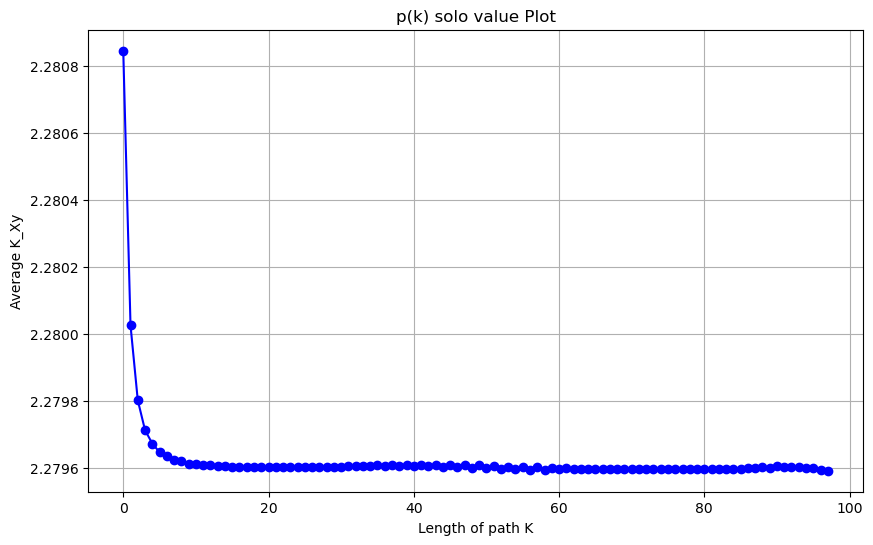

In [ ]:
#Graph at 20,15

#Smaller K_Xy is better

#Identity Kernel
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloID(observationsvals,forecast2vals,k+1,20,15))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

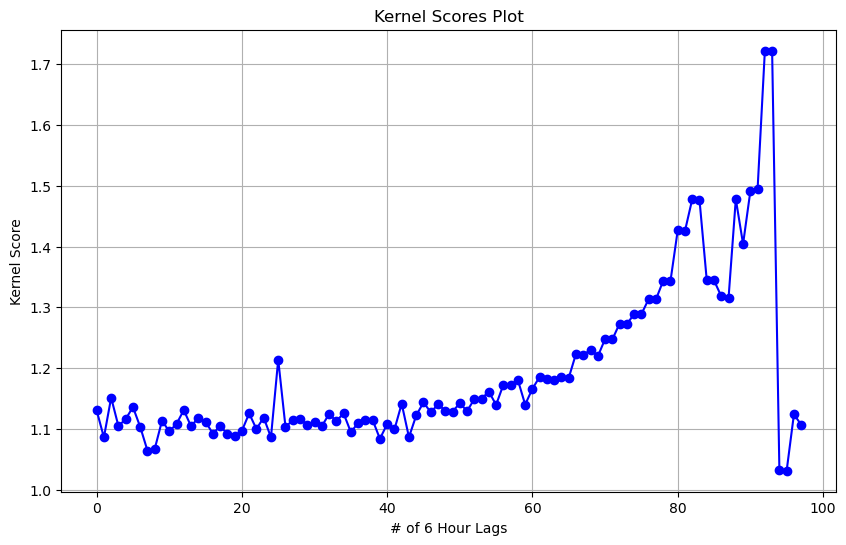

In [235]:
#Graph at 20,15

#RBF kernel
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloRBF2(observationsvals,forecast2vals,k+1,20,15))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

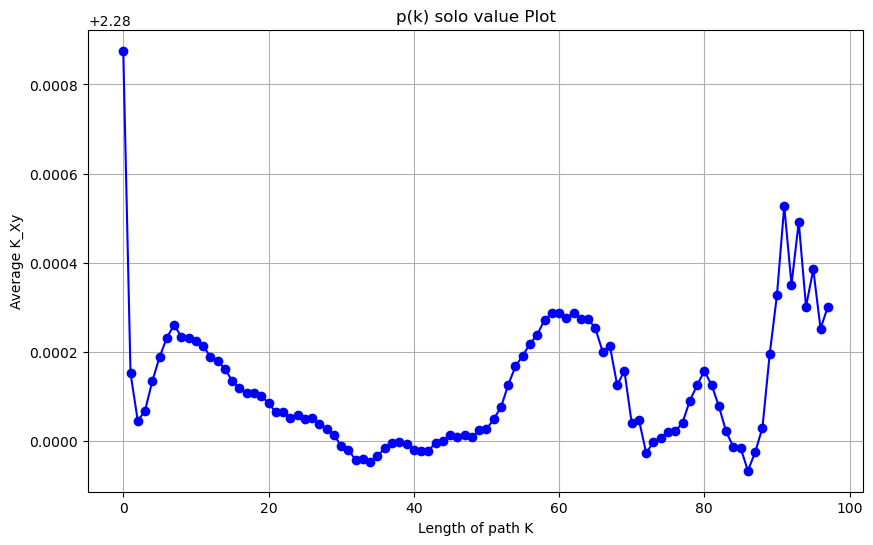

In [236]:
#Graph at 62,29
#Different points

#Identity Kernel
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloID(observationsvals,forecast2vals,k+1,62,29))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

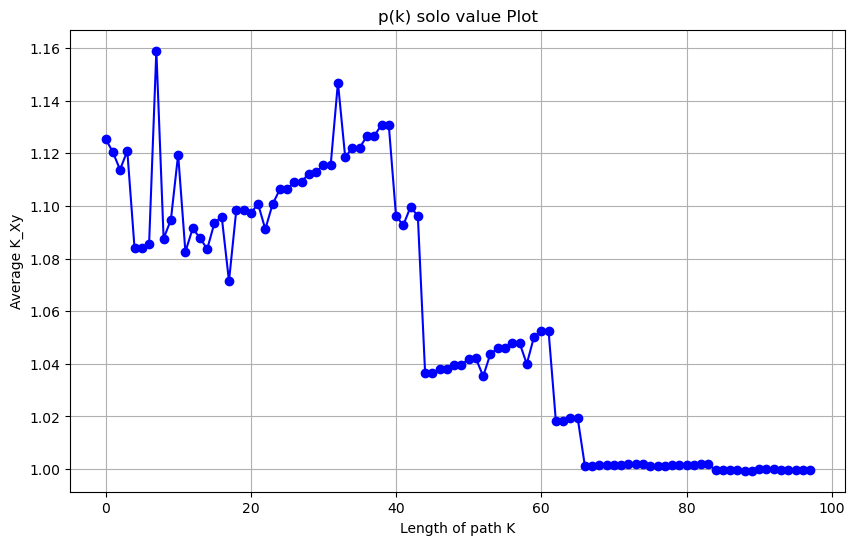

In [ ]:
#Graph at 62,29
#Different points

#RBF Kernel no scaling
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloRBF2(observationsvals,forecast2vals,k+1,62,29))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

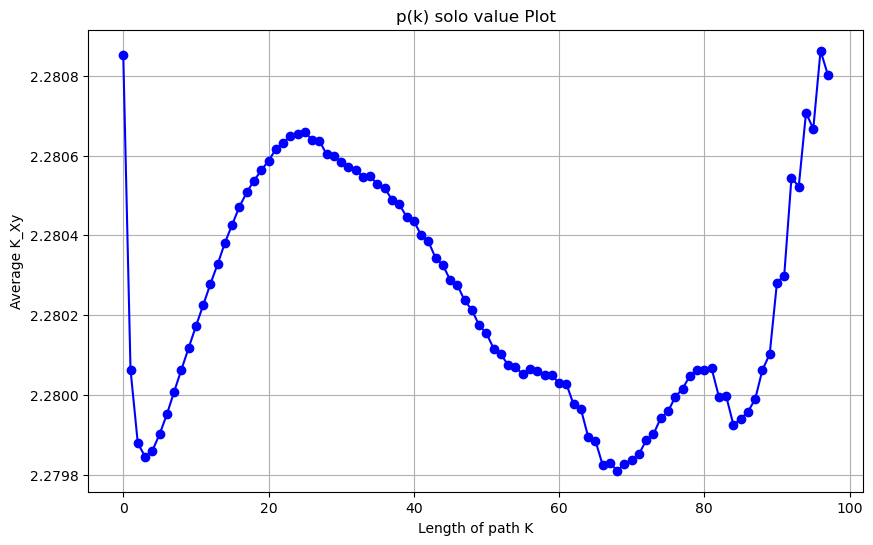

In [238]:
#Graph at 63,31
#Different points

#Identity Kernel
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloID(observationsvals,forecast2vals,k+1,63,31))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

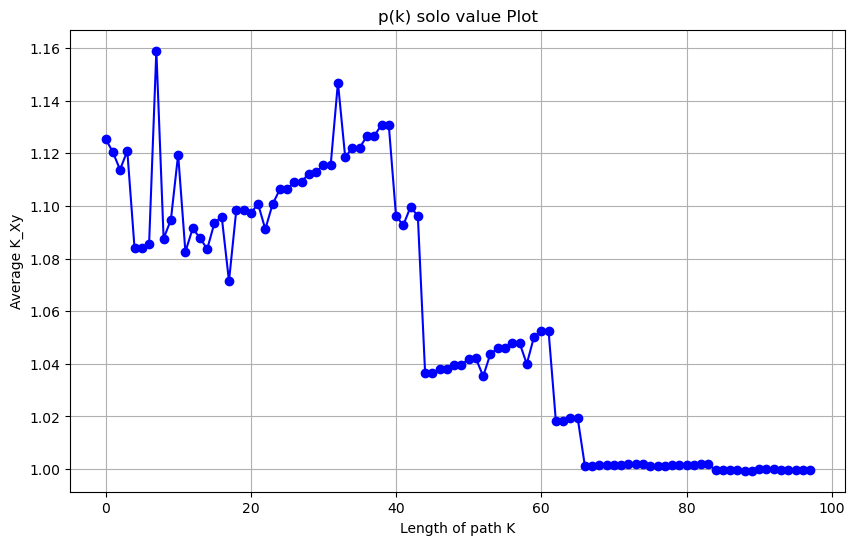

In [239]:
#Graph at 62,29
#Different points

#Identity Kernel
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloRBF2(observationsvals,forecast2vals,k+1,62,29))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

In [297]:
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloID(observationsvals,forecast2vals,k+1,20,15))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484


KeyboardInterrupt: 

In [46]:
#Forecast 3 and Forecast 2
forecast2vals = forecast2['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

In [47]:
forecast3vals = forecast3['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

In [48]:
forecast4vals = forecast4['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

In [49]:
forecast5vals = forecast5['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

In [247]:
print(forecast2vals.shape)
print(forecast3vals.shape)

(50, 61, 64, 32)
(50, 41, 64, 32)


In [ ]:
duo = [forecast2vals,forecast3vals]

array([[[[49871.44 , 50181.46 , 50389.77 , ..., 49289.156, 48643.73 ,
          48313.37 ],
         [49855.53 , 50209.984, 50366.375, ..., 49323.266, 48670.95 ,
          48348.734],
         [49846.   , 50265.656, 50378.004, ..., 49284.11 , 48671.32 ,
          48373.965],
         ...,
         [49906.55 , 50259.387, 50400.77 , ..., 48840.215, 48313.434,
          48100.39 ],
         [49897.47 , 50214.094, 50442.574, ..., 49053.78 , 48469.895,
          48191.11 ],
         [49885.58 , 50185.137, 50422.363, ..., 49194.45 , 48572.594,
          48263.42 ]],

        [[49778.33 , 50109.18 , 50249.87 , ..., 49301.95 , 48672.586,
          48492.44 ],
         [49776.523, 50134.637, 50245.035, ..., 49357.953, 48714.56 ,
          48518.61 ],
         [49772.984, 50180.52 , 50255.906, ..., 49332.54 , 48719.254,
          48529.137],
         ...,
         [49762.297, 50141.31 , 50223.484, ..., 48714.09 , 48334.496,
          48321.75 ],
         [49771.074, 50116.36 , 50264.664, ..., 48

In [306]:
len(duo)

2

[[[[49871.44  50181.46  50389.77  ... 49289.156 48643.73  48313.37 ]
   [49855.53  50209.984 50366.375 ... 49323.266 48670.95  48348.734]
   [49846.    50265.656 50378.004 ... 49284.11  48671.32  48373.965]
   ...
   [49906.55  50259.387 50400.77  ... 48840.215 48313.434 48100.39 ]
   [49897.47  50214.094 50442.574 ... 49053.78  48469.895 48191.11 ]
   [49885.58  50185.137 50422.363 ... 49194.45  48572.594 48263.42 ]]

  [[49778.33  50109.18  50249.87  ... 49301.95  48672.586 48492.44 ]
   [49776.523 50134.637 50245.035 ... 49357.953 48714.56  48518.61 ]
   [49772.984 50180.52  50255.906 ... 49332.54  48719.254 48529.137]
   ...
   [49762.297 50141.31  50223.484 ... 48714.09  48334.496 48321.75 ]
   [49771.074 50116.36  50264.664 ... 48977.56  48492.16  48393.484]
   [49776.42  50104.613 50267.297 ... 49172.613 48600.336 48450.39 ]]

  [[49785.26  50106.61  50196.16  ... 49297.816 48747.84  48656.79 ]
   [49802.6   50139.76  50199.395 ... 49372.57  48778.676 48672.855]
   [49818.06  50

In [258]:
def findscaleall(obs,fors):
    realmax = obs.max()
    for val in fors:
        realmax = np.array([val.max(),realmax]).max()

    return realmax

In [330]:
np.std(observationsvals)

3302.5408

In [334]:
def pkduo(observations,forecasts,k,long,lat):
    #Find more notes on function in ReframingSigKernel.ipynb
    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        # max = findscaleall(observations, forecasts)
        # observations = observations/max
        # for i in range(len(forecasts)):
        #      forecasts[i] = forecasts[i]/max

        j = long
        l= lat 

        meanobs = sum(observations[:,j,l]/len(observations[:,j,l]))

        observations = observations/meanobs
        for i in range(len(forecasts)):
              forecasts[i] = forecasts[i]/meanobs

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts[0].shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)


        vals = [None]*len(forecasts)

        count = 0
        for val in forecasts:
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = val[i,0:k+1,j,l]
                obs = observations[2*i:2*i+k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                grid[i] = K_Xy.item()
            
            vals[count] = sum(grid/shiftedtime)
            count+=1
        
        return(vals)

        #return (forecasts)

In [356]:
#Need to fix output from list to array
def pkduominus(observations,forecasts,k,long,lat):
        j = long
        l= lat 

        meanobs = sum(observations[:,j,l]/len(observations[:,j,l]))
        std = np.std(observations[:,j,l])
        observations = (observations-meanobs)/std
        
        for i in range(len(forecasts)):
              forecasts[i] = (forecasts[i]-meanobs)/std

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts[0].shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)


        vals = np.zeros(len(forecasts))

        count = 0
        for f in range(len(forecasts)):
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = forecasts[f][i,0:k+1,j,l]
                obs = observations[2*i:2*i+k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                grid[i] = K_Xy.item()
            
            vals[count] = sum(grid/shiftedtime)
            count+=1
        
        return(vals)

In [368]:
test = pkduo(observationsvals,[forecast2vals,forecast3vals],5,20,15)

In [392]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,20,15)

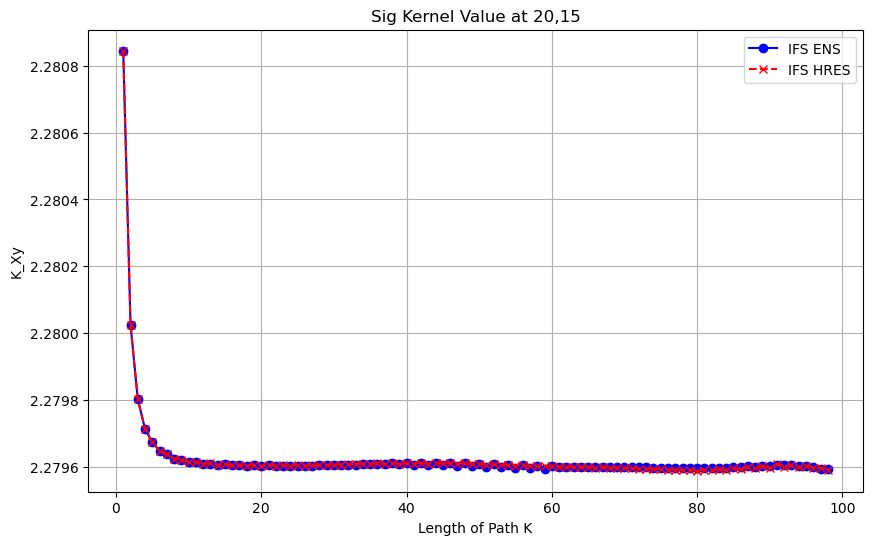

In [335]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,20,15)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 20,15")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

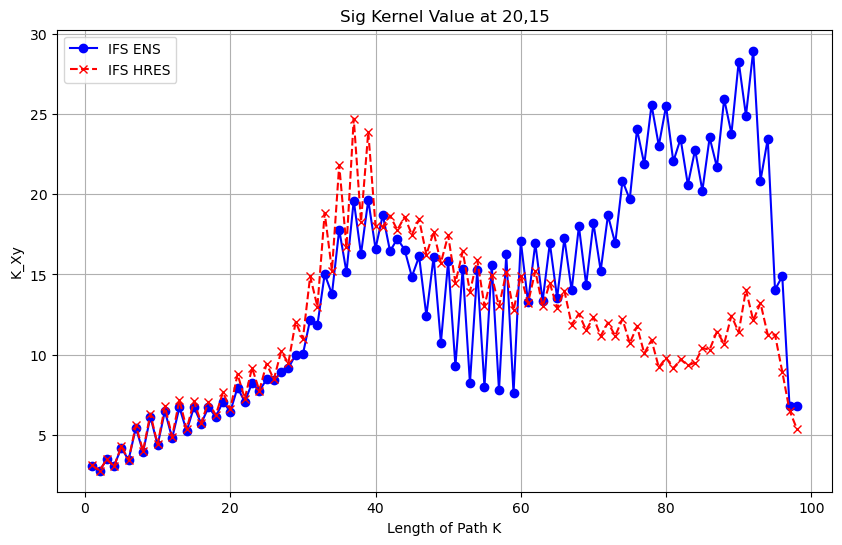

In [367]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,20,15)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 20,15")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

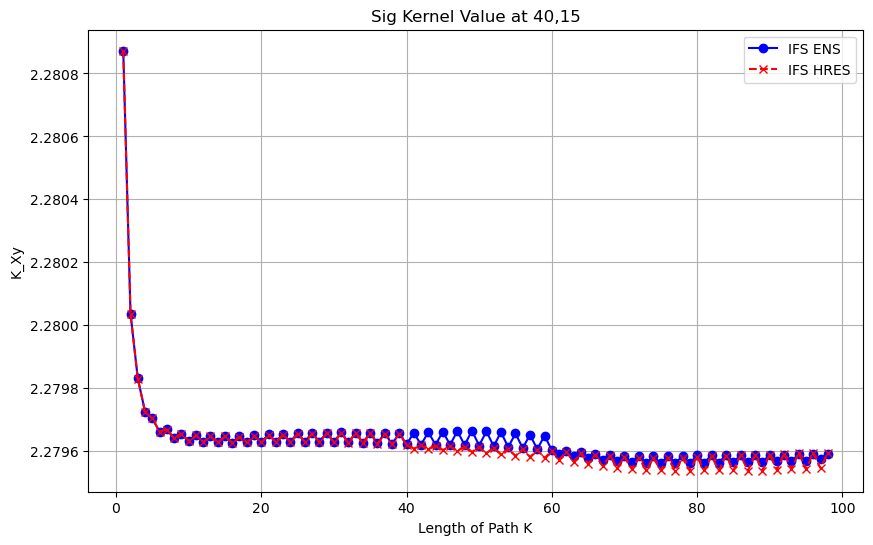

In [321]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,40,15)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 40,15")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

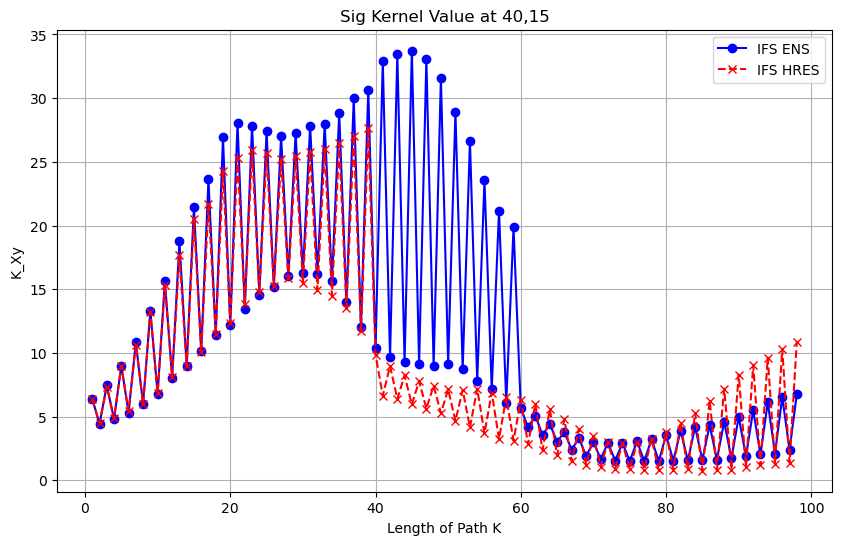

In [333]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,40,15)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 40,15")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

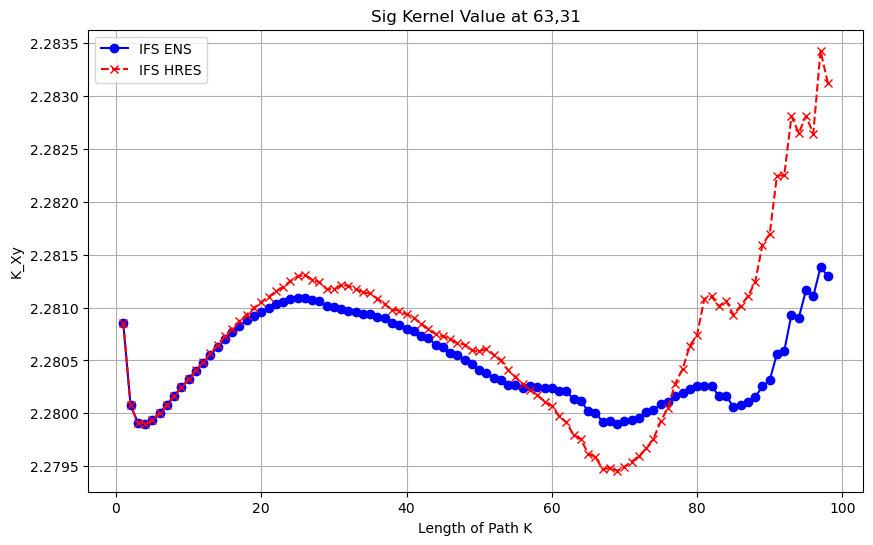

In [322]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,63,31)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 63,31")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

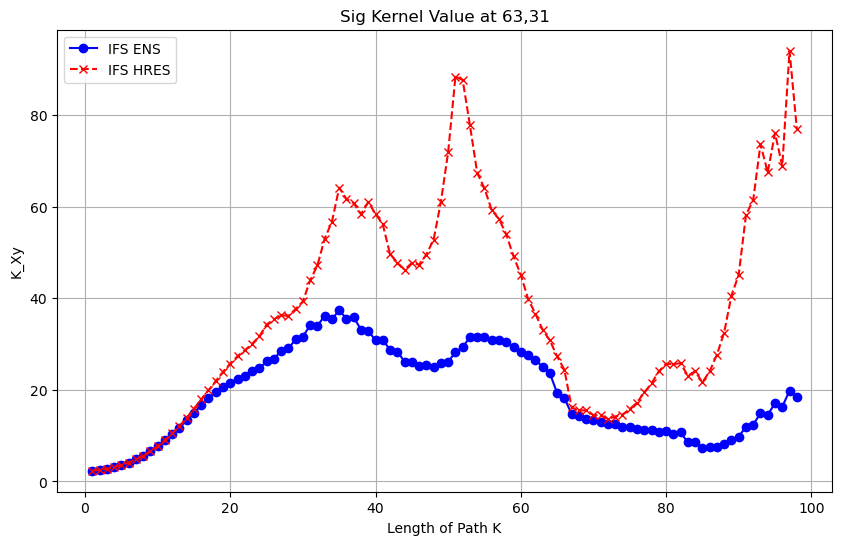

In [340]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,63,31)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 63,31")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

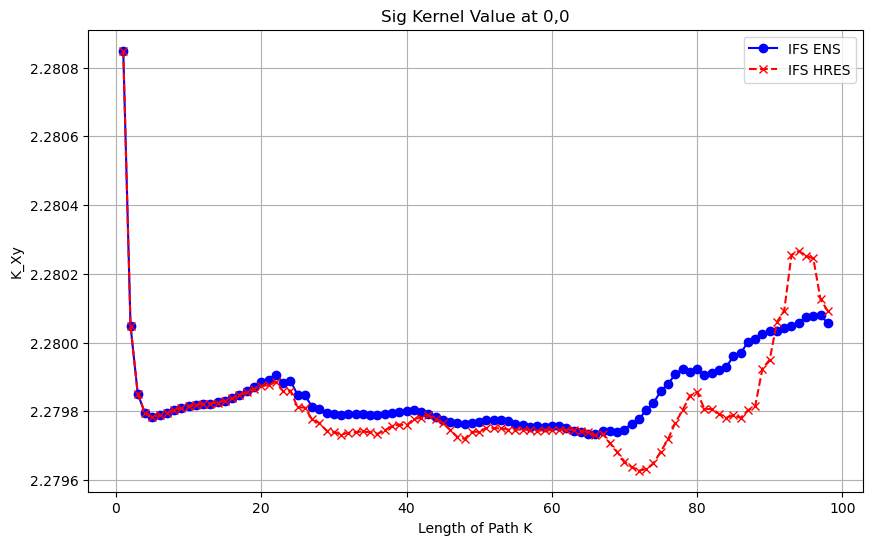

In [323]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,0,0)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 0,0")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

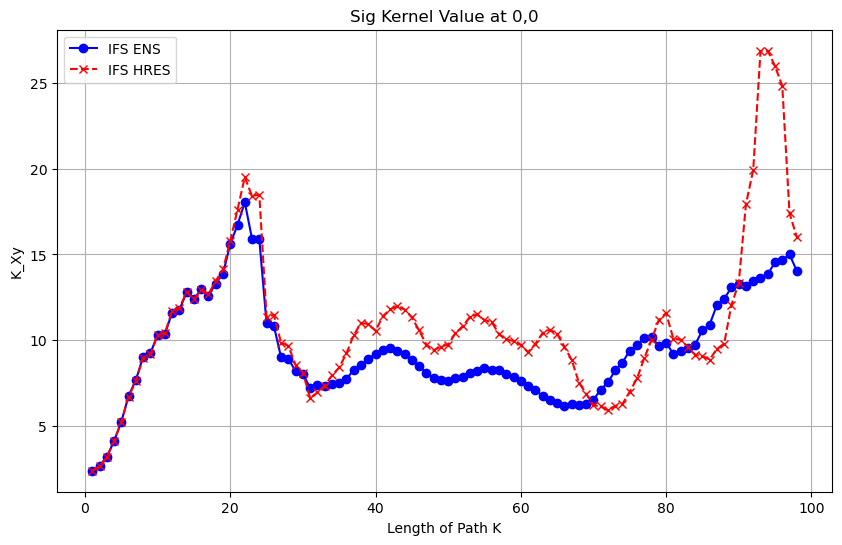

In [341]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,0,0)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 0,0")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

In [342]:
vals1 =[None]*98
vals2 =[None]*98
for k in range(98):
    vals1[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,0,0)
for k in range(98):
    vals2[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,63,31)

In [ ]:
vals1 = [list(col) for col in zip(*vals1)]
vals2 = [list(col) for col in zip(*vals2)]
vals1

[[2.365462079984967,
  2.636758441663443,
  3.1620083858127885,
  4.097263370553598,
  5.2240080902271355,
  6.73254200901042,
  7.655462487954401,
  9.011267602360437,
  9.217332917779634,
  10.313627627681797,
  10.350211813055632,
  11.599057033925964,
  11.759869522071977,
  12.805586302269436,
  12.407658971468305,
  12.959299030064159,
  12.59018531310816,
  13.295407683614163,
  13.868379654810282,
  15.606720368683177,
  16.72569695147583,
  18.042273727738838,
  15.90654717593725,
  15.876165212316334,
  10.967863125469977,
  10.82959435619556,
  8.98282838941362,
  8.90157586540315,
  8.173611408859108,
  8.016424705768998,
  7.206879266908626,
  7.347315225081486,
  7.326912624009517,
  7.40678780901376,
  7.465599966408833,
  7.746794865333407,
  8.236841885210804,
  8.529151603183873,
  8.898772791389836,
  9.191984009100004,
  9.438678139013021,
  9.543555490314985,
  9.364954435323213,
  9.181521823332488,
  8.80518298040254,
  8.46042555203944,
  8.090963852048535,
  7.

In [413]:
sumcol1 = np.add(vals1[0],vals2[0])
sumcol2 = np.add(vals1[1],vals2[1])

array([ 4.70017675,  5.13379811,  5.91625172,  7.203615  ,  8.7744931 ,
       10.84568776, 12.45936032, 14.64051172, 15.81211203, 18.0009908 ,
       19.31219903, 21.91353179, 23.53151555, 26.12006634, 27.29996409,
       29.61215261, 30.76551697, 32.87304827, 34.50983467, 37.07294821,
       39.13701378, 41.121129  , 40.01645737, 40.56229753, 37.17404825,
       37.62040418, 37.48003528, 37.99160166, 39.18531009, 39.67001546,
       41.3157744 , 41.34731084, 43.53048074, 42.89321683, 44.85197186,
       43.33621891, 44.09809474, 41.70308431, 41.8201091 , 39.99309621,
       40.32770454, 38.30304119, 37.71729164, 35.38060187, 34.89064552,
       33.62809838, 33.57390419, 32.84284296, 33.42053873, 33.79710515,
       35.930697  , 37.19711689, 39.58519247, 39.78280074, 39.88421572,
       39.19084977, 39.10477624, 38.48766145, 37.11947615, 35.94666674,
       34.94350761, 33.58500273, 31.84731164, 30.12470368, 25.67682642,
       24.35481714, 20.97340225, 20.52752693, 19.81944481, 19.82

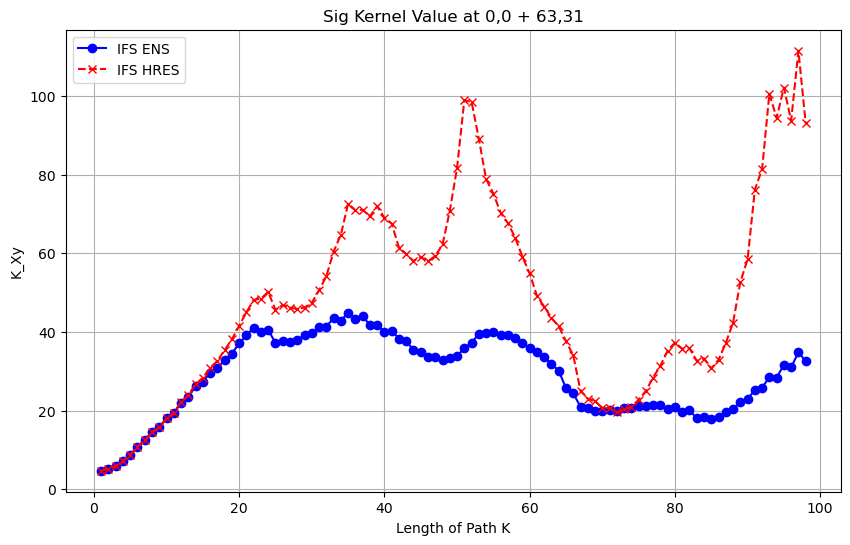

In [ ]:
first_elements = sumcol1
second_elements = sumcol2
x_values = range(1, len(sumcol2) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 0,0 + 63,31")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In [37]:
#Iterate over all latitude values for a specific longitutde. Apply weighting. Fix outputs. 
#Scale all points by same, or can different positions be scaled?
def scalemean(observations):
      return (np.sum(observations/np.size(observations)))

def scalestd(observations):
      return (np.std(observations))

def scaleall(observations, forecasts):
      mean = scalemean(observations)
      std = scalestd(observations)
      observations = (observations-mean)/std
      for i in range(len(forecasts)):
              forecasts[i] = (forecasts[i]-mean)/std
      return([observations,forecasts])

 
def pkscaleall(observations,forecasts,k,long,lat):
        j = long
        l= lat 

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts[0].shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)

        vals = np.zeros(len(forecasts))

        count = 0
        for f in range(len(forecasts)):
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = forecasts[f][i,0:k+1,j,l]
                obs = observations[2*i:2*i+k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                grid[i] = K_Xy.item()
            
            vals[count] = sum(grid/shiftedtime)
            count+=1
        
        return(vals)

In [4]:
latitude = forecast1['latitude'][:].values
delta = 2.8125
theta_upper = latitude + delta
theta_lower = latitude - delta

# Calculate weights based on the provided formula
weights = (np.sin(np.radians(theta_upper)) - np.sin(np.radians(theta_lower)))
weights /= weights.sum()
weights *= 32

weights

NameError: name 'forecast1' is not defined

In [3]:
forecast1['latitude'][:].values

NameError: name 'forecast1' is not defined

In [ ]:
quad = [forecast2vals,forecast3vals,forecast4vals,forecast5vals]
test = scaleall(observationsvals,quad)

grid = np.zeros((32,64,98,4))

for lat in range(32): #32
    for long in range(64) #64
    for k in range(98): #98
        vals = pkscaleall(test[0],test[1],k+1,long,lat)
        
        for i in range(len(quad)):
            grid[lat,long,k,i] = vals[i]


In [ ]:
#Could iterate over all lat, consider long together instead of 1by1

In [31]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor

quad = [forecast2vals,forecast3vals,forecast4vals,forecast5vals]
test = scaleall(observationsvals,quad)

# Function to compute the values for each grid point
def compute_values(lat, k, test, quad):
    vals = pkscaleall(test[0], test[1], k + 1, 30, lat)
    return lat, k, vals

# Initialize grid
grid = np.zeros((32, 98, 4))

# Parallel execution
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(compute_values, lat, k, test, quad)
        for lat in range(32)
        for k in range(98)
    ]
    for future in futures:
        lat, k, vals = future.result()
        for i in range(len(quad)):
            grid[lat, k, i] = vals[i]


In [39]:
quad = [forecast2vals,forecast3vals,forecast4vals,forecast5vals]
test = scaleall(observationsvals,quad)

grid = np.zeros((32,98,4))

for lat in range(32): #32
    for k in range(98): #98
        vals = pkscaleall(test[0],test[1],k+1,30,lat)
        
        for i in range(len(quad)):
            grid[lat,k,i] = vals[i]



In [33]:
grid

array([[[2.281808  , 2.28180884, 2.28187732, 2.28167375],
        [2.2842642 , 2.28421992, 2.28433316, 2.283869  ],
        [2.28740896, 2.28733424, 2.28728697, 2.28689517],
        ...,
        [2.32617515, 2.38448296, 2.27767794, 2.26774534],
        [2.28836637, 2.31476799, 2.22408719, 2.25469861],
        [2.2880031 , 2.30537622, 2.23950358, 2.261437  ]],

       [[2.28210232, 2.28212855, 2.28213543, 2.28201471],
        [2.28435869, 2.2843448 , 2.28438137, 2.28398153],
        [2.28856045, 2.28863404, 2.28857665, 2.28781703],
        ...,
        [2.35308832, 2.38608654, 2.33789292, 2.35195709],
        [2.32584272, 2.37446849, 2.30714673, 2.32803898],
        [2.33816864, 2.3754615 , 2.33240439, 2.34784142]],

       [[2.28256409, 2.28263156, 2.28261967, 2.28254995],
        [2.28667535, 2.28660633, 2.28669647, 2.28636539],
        [2.29329103, 2.29333981, 2.2935194 , 2.29284455],
        ...,
        [2.82793021, 2.83211234, 2.82668508, 2.87890186],
        [2.79103498, 2.746336

In [34]:
grid1 = (grid*weights.reshape(-1,1,1))

In [ ]:

np.sum(grid1, axis=0)

array([[73.20499424, 73.20783652, 73.21929154, 73.21779318],
       [73.60118813, 73.60038406, 73.60999139, 73.6054378 ],
       [74.2417862 , 74.24237479, 74.26632332, 74.24516121],
       [74.8613881 , 74.86020115, 74.88418755, 74.85572377],
       [75.50494678, 75.51164344, 75.54605345, 75.4886134 ],
       [76.00941756, 76.01266476, 76.04316319, 75.98194312],
       [76.45840875, 76.46543397, 76.50579155, 76.43494544],
       [76.79705121, 76.80727355, 76.83523987, 76.74950514],
       [77.1245686 , 77.14734003, 77.17520574, 77.09695098],
       [77.40427973, 77.43940039, 77.44959977, 77.37086986],
       [77.71206202, 77.77209561, 77.77601415, 77.71468491],
       [77.98271852, 78.06721917, 78.05394002, 78.00810635],
       [78.27971424, 78.39232316, 78.39694829, 78.37131968],
       [78.56649221, 78.70146366, 78.69681322, 78.6669651 ],
       [78.84654021, 78.99170407, 79.00761725, 79.01421261],
       [79.094859  , 79.27275413, 79.26407485, 79.28489083],
       [79.32394249, 79.

In [ ]:
vals = np.transpose(np.sum(grid1, axis=0))

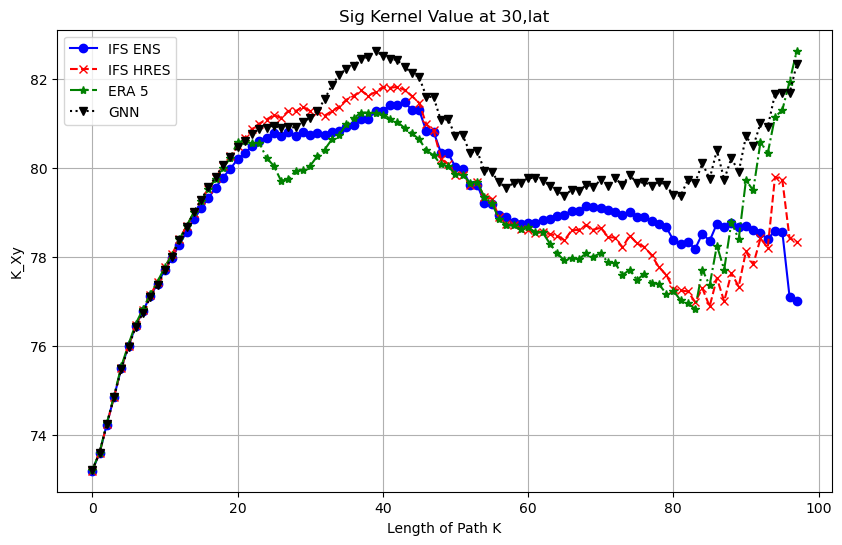

In [37]:
x_values = range(98)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, vals[0], marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, vals[1], marker='x', linestyle='--', color='r', label="IFS HRES")
plt.plot(x_values, vals[2], marker='*', linestyle='-.', color='g', label="ERA 5")
plt.plot(x_values, vals[3], marker='v', linestyle=':', color='k', label="GNN")


# Add titles and labels
plt.title("Sig Kernel Value at 30,lat")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

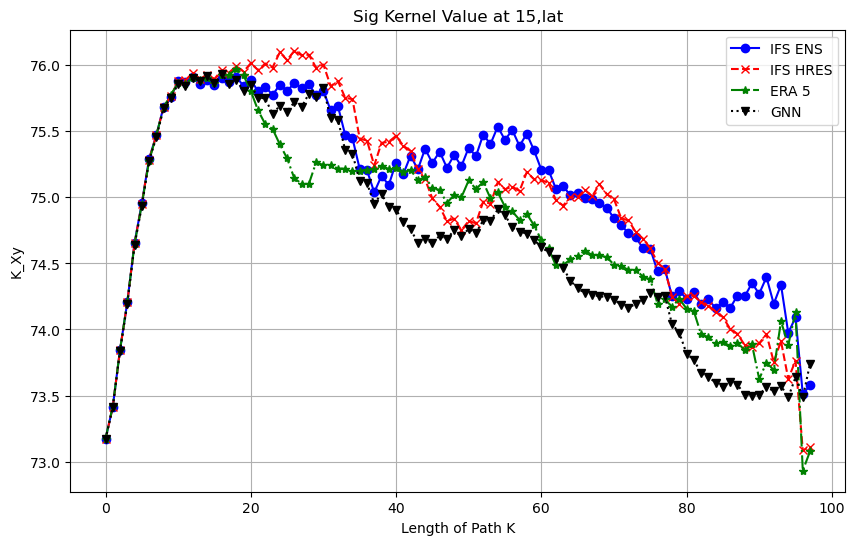

In [585]:
x_values = range(98)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, vals[0], marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, vals[1], marker='x', linestyle='--', color='r', label="IFS HRES")
plt.plot(x_values, vals[2], marker='*', linestyle='-.', color='g', label="ERA 5")
plt.plot(x_values, vals[3], marker='v', linestyle=':', color='k', label="GNN")


# Add titles and labels
plt.title("Sig Kernel Value at 15,lat")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

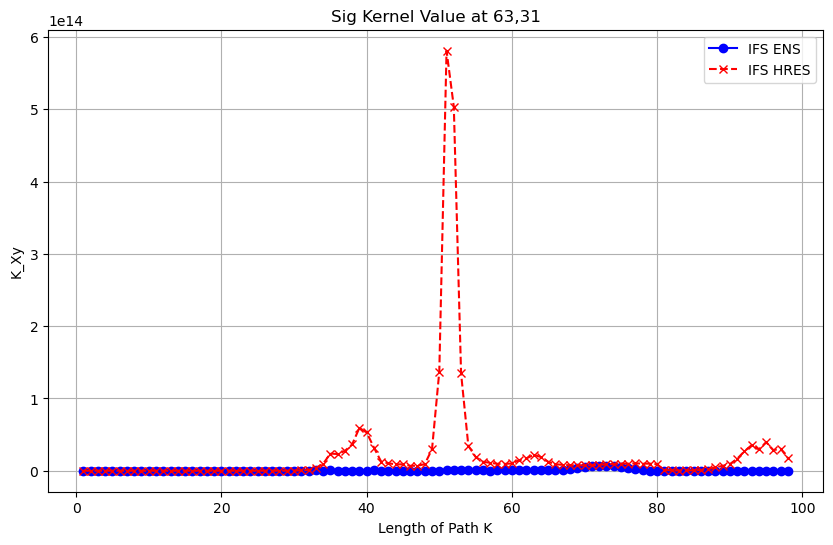

In [293]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,63,31)


first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 63,31")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In [38]:
import torch

def scalemean(observations):
    return torch.sum(observations) / observations.numel()

def scalestd(observations):
    return torch.std(observations)

def scaleall(observations, forecasts):
    mean = scalemean(observations)
    std = scalestd(observations)
    
    # Scale observations
    observations = (observations - mean) / std
    
    # Scale forecasts
    forecasts = [(forecast - mean) / std for forecast in forecasts]
    
    return [observations, forecasts]


In [39]:
import math
import torch
import sigkernel

def pkscaleall(observations, forecasts, k, long, lat):
    j = long
    l = lat

    static_kernel = sigkernel.Linear_ID_Kernel()  # Linear kernel
    dyadic_order = 2
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
    
    time = forecasts[0].shape[0]
    shiftedtime = math.floor(time - 0.5 * k)

    vals = torch.zeros(len(forecasts), device="cuda")  # Allocate result on GPU

    for f in range(len(forecasts)):
        grid = torch.zeros(shiftedtime, device="cuda")  # Allocate grid on GPU

        for i in range(shiftedtime):
            fors = forecasts[f][i, 0:k + 1, j, l]
            obs = observations[2 * i:2 * i + k + 1, j, l]

            fors = fors.unsqueeze(0)  # Expand dims for compatibility
            obs = obs.unsqueeze(0)

            llobs = sigkernel.transform(obs.cpu().numpy(), scale=1, at=True, ll=False)
            llfors = sigkernel.transform(fors.cpu().numpy(), scale=1, at=True, ll=False)

            # Convert back to PyTorch tensors
            X = torch.tensor(llfors, dtype=torch.double, device="cuda")
            y = torch.tensor(llobs, dtype=torch.double, device="cuda")

            # Compute Gram matrix
            K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)

            grid[i] = K_Xy.item() #maybe remove item

        vals[f] = torch.sum(grid) / shiftedtime  # Average grid values

    return vals

In [40]:
# Convert observations and forecasts to PyTorch tensors
observationsvals = torch.tensor(observationsvals, device="cuda", dtype=torch.float)
quad = [torch.tensor(q, device="cuda", dtype=torch.float) for q in [forecast2vals, forecast3vals, forecast4vals, forecast5vals]]

# Scale data
test = scaleall(observationsvals, quad)

# Initialize the grid on GPU
grid = torch.zeros((32, 98, 4), device="cuda")

# Main computation loop
for lat in range(32):
    for k in range(98):
        vals = pkscaleall(test[0], test[1], k + 1, 30, lat)
        grid[lat, k, :len(quad)] = vals

# Convert back to NumPy if needed
grid_np = grid.cpu().numpy()


c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


KeyboardInterrupt: 

In [86]:
#### Rechecking on ensemble model, #Split into 2 and test
#forecast1test = forecast1['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

def scalemean(observations):
      return (np.sum(observations/np.size(observations)))

def scalestd(observations):
      return (np.std(observations))

def scaleENS(observations, forecasts):
      mean = scalemean(observations)
      std = scalestd(observations)
      observations = (observations-mean)/std
      forecasts = (forecasts-mean)/std

      return([observations,forecasts])

 
#Not latitudely weighted
def pkscaleENS(observations,forecasts,k):
      static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
      dyadic_order = 2
      signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
      time = forecasts.shape[0]
      #print(time) #All forecasts on same time frame
      shiftedtime = math.floor(time- 0.5*k)

      vals = 0
      count =0

      for i in range(shiftedtime): #20
            fors = forecasts[i,:,0:k+1,:,:]
            obs = observations[2*i:2*i+k+1,:,:]

            fors = fors.reshape(forecasts.shape[1],k+1,forecasts.shape[3]*forecasts.shape[4])
            obs = obs.reshape(-1,forecasts.shape[3]*forecasts.shape[4])

            obs = np.expand_dims(obs, axis = 0)
            
            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
            llfors = sigkernel.transform(fors, scale = 1/np.sqrt(forecasts.shape[3]*forecasts.shape[4]*forecasts.shape[1]), at = True, ll = False)

            X = torch.tensor(llfors, dtype=torch.double)
            y = torch.tensor(llobs, dtype=torch.double)



            val = signature_kernel.compute_scoring_rule(X,y).item()
            #print(val)
            vals = vals + val
            count+=1
        
      return(vals/count)


In [64]:
half1forecastvals = forecast1vals[:,0:25,:,:,:]
print(half1forecastvals.shape)
half2forecastvals = forecast1vals[:,25:50,:,:,:]
print(half2forecastvals.shape)


(50, 25, 61, 64, 32)
(50, 25, 61, 64, 32)


In [ ]:
#Same scale
test = scaleENS(observationsvals,forecast1vals)

#all models very similar
print(test[1][0,23,0,0,:])
print("yo")
print(test[1][0,46,0,0,:])

[-1.2499739  -1.1513921  -1.0883133  -1.2909994  -1.4032437  -1.264863
 -0.8717779  -0.25940374  0.33275634  0.7636852   1.0506269   1.1456662
  1.1586604   1.1314394   1.1087687   1.1028346   1.1115435   1.1080307
  1.0601875   0.96010476  0.91338414  0.92205995  0.97024375  0.91693014
  0.6313924   0.66742766  0.46382022 -0.18442832 -0.99758655 -1.4158854
 -1.6135907  -1.7098424 ]
yo
[-1.2484162  -1.1582643  -1.0927371  -1.299699   -1.4100945  -1.277623
 -0.8833989  -0.2582588   0.33258957  0.76262426  1.0536501   1.1489284
  1.1653067   1.1301951   1.1035691   1.1058472   1.1169655   1.1117955
  1.0584358   0.9612355   0.9151086   0.9208204   0.9685157   0.91355324
  0.63701904  0.6730779   0.46764067 -0.18183798 -0.99282813 -1.4204144
 -1.6251822  -1.7214031 ]


In [ ]:
#Same scale
test = scaleENS(observationsvals,forecast1vals)



gridT2 = np.zeros(98)

for k in range(98): #98
    val = pkscaleENS(test[0],test[1],k+1)
    print(val)
    gridT2[k] = val



-2.4129564691130656
-2.4129539403728475
-2.681983627052869
-2.6819753233752257
-3.083152200667296
-3.083083807499513
-3.5075235994554195
-3.507565014477516
-3.9941282651703567
-3.9941869623760637
-4.451211013573096
-4.451543532205301
-4.938194530877536
-4.938501242235415
-5.374443118457463
-5.374728634632083
-5.8335121423513705
-5.833059443271353
-6.243127712753051
-6.242081396526951
-6.674070940069535
-6.672448858814881
-7.073778312162417
-7.072044015509706
-7.502812416143897
-7.500298515807756
-7.91900418096968
-7.91583113065262
-8.360486005294561
-8.354704403778086
-8.791749912671674
-8.784919942004256
-9.251231291201993
-9.242588913124813
-9.68802494714393
-9.678141425804592
-10.13416848254097
-10.125450855079414
-10.554894773030572
-10.546291995500596
-10.968683885539498
-10.960318430869956
-11.3648828226057
-11.360494564732297
-11.729154608187045
-11.726164321379642


KeyboardInterrupt: 

In [ ]:
#Same scale, now 5 vs 45 (scale is not correct to account for number of models (i.e. not 1/ sqrt (model))))
test = scaleENS(observationsvals,forecast1vals)

test[1]

half1forecastvals = test[1][:,0:5,:,:,:]
half2forecastvals = test[1][:,5:50,:,:,:]

gridT2 = np.zeros((98,2))

for k in range(98): #98
    val1 = pkscaleENS(test[0],half1forecastvals,k+1)
    val2 = pkscaleENS(test[0],half2forecastvals,k+1)
    print(val1)
    print(val2)
    gridT2[k,0] = val1
    gridT2[k,1] = val2

-2.5786585193588536
-2.379145101074173
-3.2113080337138102
-2.577442719132646
-4.210684934219496
-2.8697367517017356
-5.377055550005846
-3.1725505403211582
-6.840353050120759
-3.5131048609620583


KeyboardInterrupt: 

In [83]:
half1forecastvals = test[1][:,0:5,:,:,:]
half1forecastvals.shape[0]

50

In [ ]:
def scalemean(observations):
      return (np.sum(observations/np.size(observations)))

def scalestd(observations):
      return (np.std(observations))

def scaleall50(observations, forecasts):
      mean = scalemean(observations)
      std = scalestd(observations)
      observations = (observations-mean)/std
      forecasts = (forecasts-mean)/std
      return([observations,forecasts])

def pkscaleall50(observations,forecasts,k,long,lat):
        j = long
        l= lat 

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts.shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)

        vals = np.zeros(forecasts.shape[1])

        for f in range(forecasts.shape[1]):
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = forecasts[i,f,0:k+1,j,l]
                obs = observations[2*i:2*i+k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                #K_XX - 2* K_Xy
                #signature_kernel.compute_scoring_rule

                grid[i] = K_Xy.item()
            
            vals[f] = sum(grid/shiftedtime)

        return(vals)

In [108]:
test50 = scaleall50(observationsvals,forecast1vals)

grid = np.zeros((98,50))
for k in range(98):
    print(k)
    all50 = pkscaleall50(test50[0],test50[1],k+1,10,15)
    grid[k,:]= all50


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


In [105]:
grid

array([[2.28984589, 2.28997272, 2.28995221, 2.28999641, 2.28991735,
        2.28966998, 2.29003521, 2.29002392, 2.28986095, 2.2898939 ,
        2.28988966, 2.2901553 , 2.28994999, 2.29006224, 2.29017173,
        2.29001949, 2.29011283, 2.28990268, 2.28992636, 2.28994982,
        2.28993023, 2.29008543, 2.29001018, 2.2899493 , 2.29006294,
        2.28990067, 2.2898199 , 2.28990267, 2.28986409, 2.28998745,
        2.28987942, 2.28982393, 2.28988646, 2.29003884, 2.28988769,
        2.28989676, 2.28982388, 2.29001056, 2.29002842, 2.2899191 ,
        2.29000836, 2.28987061, 2.28996358, 2.28990904, 2.28982724,
        2.29004633, 2.29016294, 2.2898929 , 2.28992344, 2.28990743],
       [2.28357242, 2.2836105 , 2.28362354, 2.28365141, 2.28360965,
        2.28352148, 2.2836821 , 2.28365217, 2.2836046 , 2.28357736,
        2.28360308, 2.28370409, 2.28367751, 2.2836666 , 2.28370102,
        2.2836924 , 2.28365353, 2.28358151, 2.28364622, 2.28361686,
        2.28366093, 2.2836787 , 2.28365864, 2.2

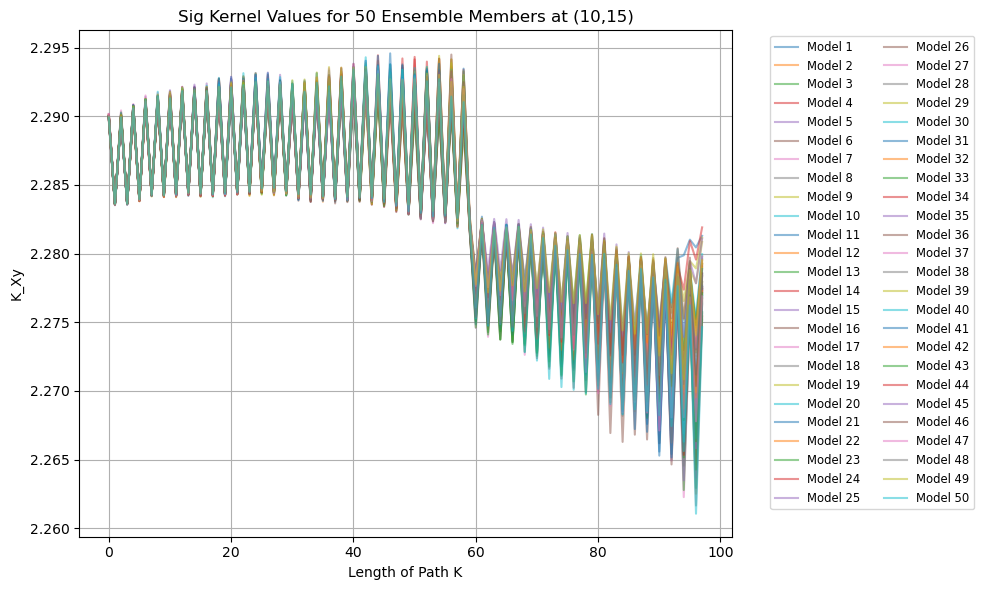

In [113]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for model_index in range(grid.shape[1]):
    plt.plot(grid[:, model_index], label=f'Model {model_index + 1}', alpha=0.5)

# Customize the plot
plt.title('Sig Kernel Values for 50 Ensemble Members at (10,15)')
plt.xlabel('Length of Path K')
plt.ylabel('K_Xy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

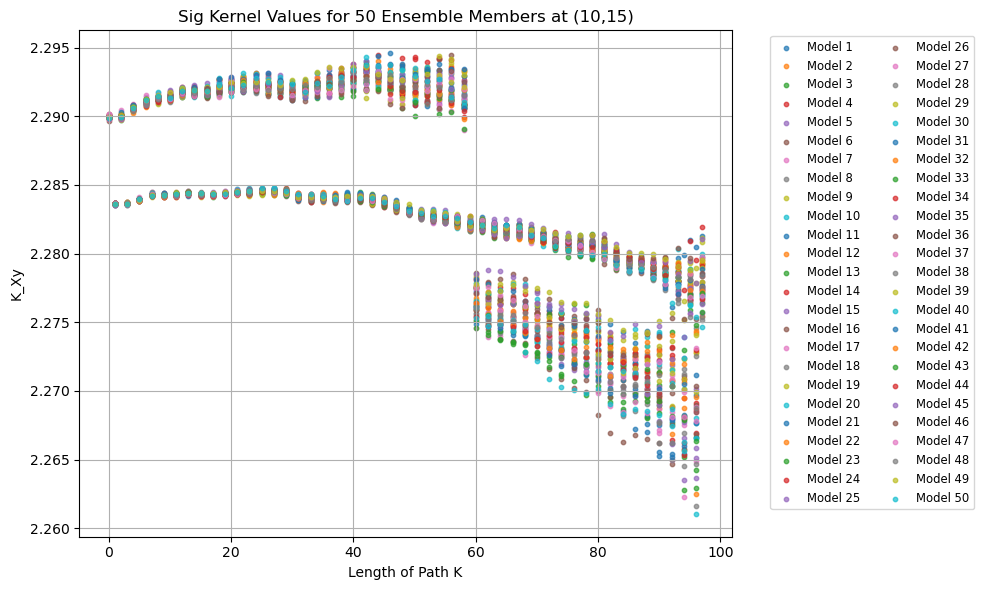

In [114]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for model_index in range(grid.shape[1]):
    plt.scatter(
        np.arange(grid.shape[0]),  # Time steps (x-axis)
        grid[:, model_index],     # Model predictions (y-axis)
        label=f'Model {model_index + 1}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )

# Customize the plot
plt.title('Sig Kernel Values for 50 Ensemble Members at (10,15)')
plt.xlabel('Length of Path K')
plt.ylabel('K_Xy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

In [115]:
test50 = scaleall50(observationsvals,forecast1vals)

grid = np.zeros((98,50))
for k in range(98):
    print(k)
    all50 = pkscaleall50(test50[0],test50[1],k+1,61,29)
    grid[k,:]= all50


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


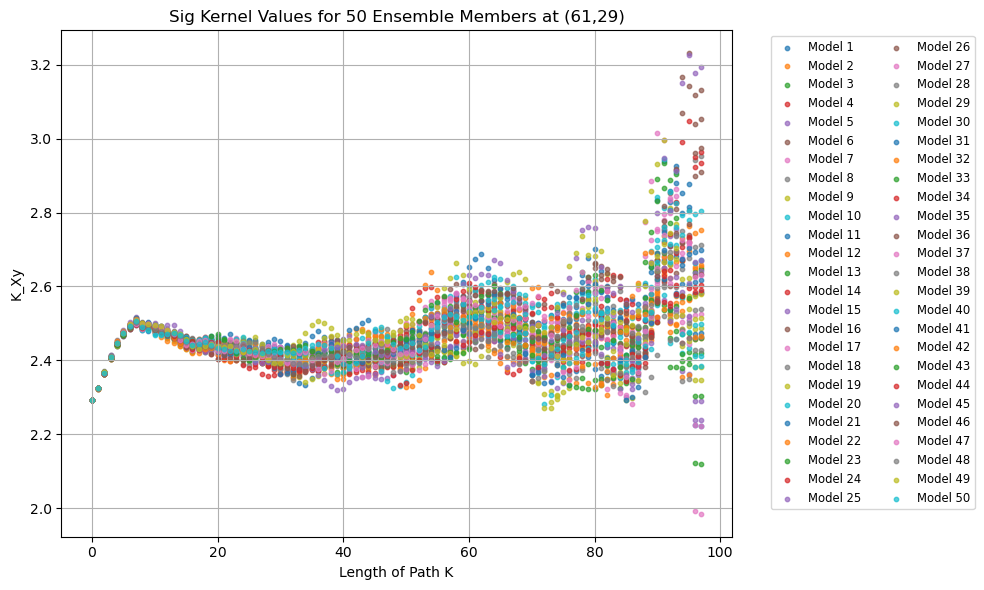

In [118]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for model_index in range(grid.shape[1]):
    plt.scatter(
        np.arange(grid.shape[0]),  # Time steps (x-axis)
        grid[:, model_index],     # Model predictions (y-axis)
        label=f'Model {model_index + 1}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )

# Customize the plot
plt.title('Sig Kernel Values for 50 Ensemble Members at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('K_Xy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

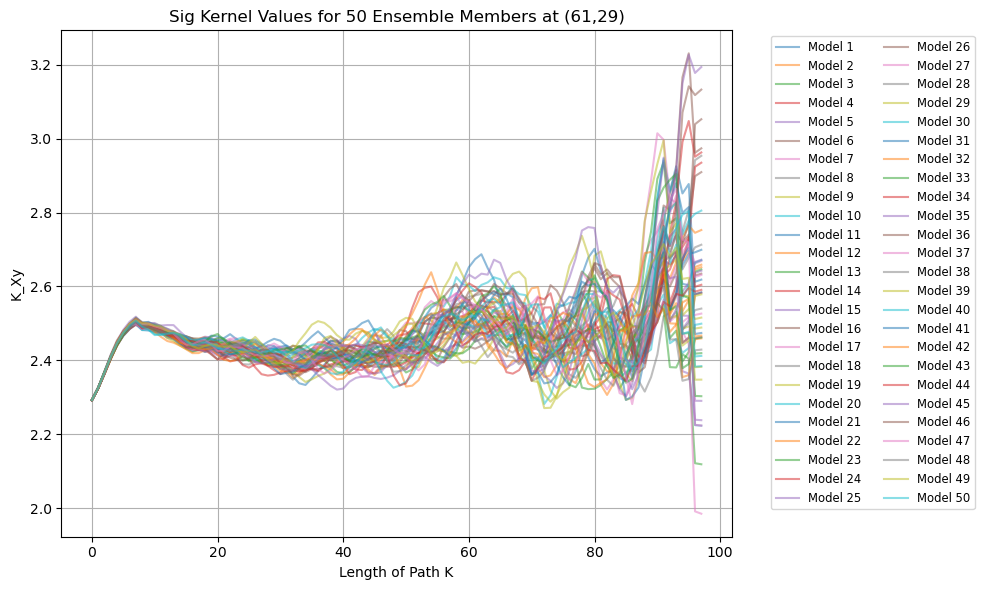

In [119]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for model_index in range(grid.shape[1]):
    plt.plot(grid[:, model_index], label=f'Model {model_index + 1}', alpha=0.5)

# Customize the plot
plt.title('Sig Kernel Values for 50 Ensemble Members at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('K_Xy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
forecast1valsextended = forecast1['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-30')).values
observationextended = xr.open_zarr(obs_path)['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-30')).values

In [10]:
test50 = scaleall50(observationextended,forecast1valsextended)

grid = np.zeros((118,50))
for k in range(118):
    print(k)
    all50 = pkscaleall50(test50[0],test50[1],k+1,61,29)
    grid[k,:]= all50

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


In [13]:
savedgrid = grid
savedgrid

array([[2.29018987, 2.29012298, 2.29026682, ..., 2.29041574, 2.29039467,
        2.29047389],
       [2.31731177, 2.31650149, 2.31737073, ..., 2.31822338, 2.31797554,
        2.31798437],
       [2.35144219, 2.34960255, 2.35059943, ..., 2.35243793, 2.35244331,
        2.35219376],
       ...,
       [2.53108344, 2.60892457, 2.43749153, ..., 2.38380065, 2.57492231,
        2.70177874],
       [2.25978462, 2.61517822, 2.58749033, ..., 2.43410207, 2.41163074,
        2.39183454],
       [2.27510105, 2.58112852, 2.54682736, ..., 2.42717663, 2.41506609,
        2.38834058]])

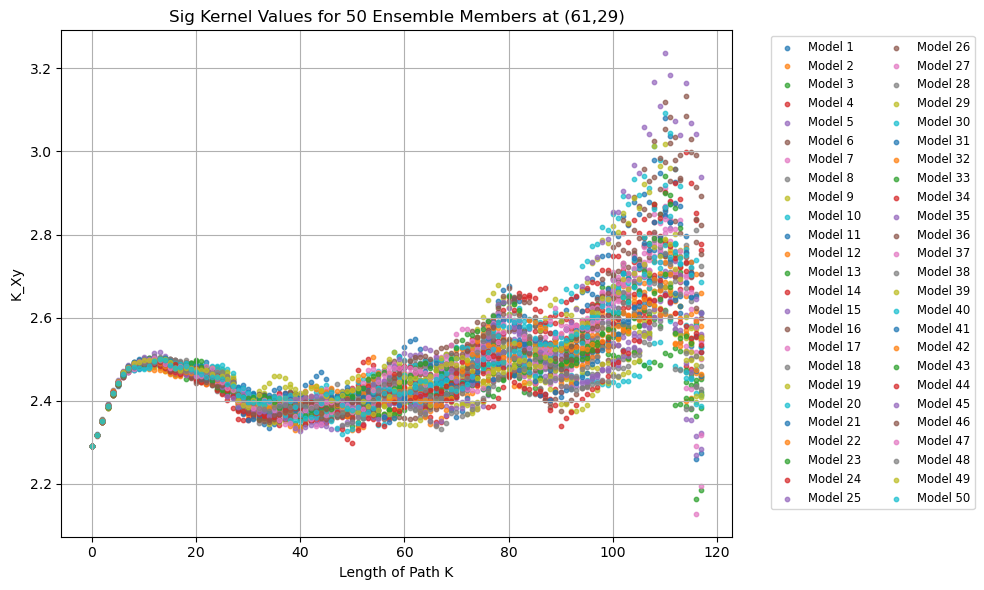

In [14]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for model_index in range(savedgrid.shape[1]):
    plt.scatter(
        np.arange(savedgrid.shape[0]),  # Time steps (x-axis)
        savedgrid[:, model_index],     # Model predictions (y-axis)
        label=f'Model {model_index + 1}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )

# Customize the plot
plt.title('Sig Kernel Values for 50 Ensemble Members at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('K_Xy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
print(observationextended.shape)
forecast1valsextended.shape

(120, 64, 32)


(60, 50, 61, 64, 32)

In [9]:
def scalemean(observations):
      return (np.sum(observations/np.size(observations)))

def scalestd(observations):
      return (np.std(observations))

def scaleall50(observations, forecasts):
      mean = scalemean(observations)
      std = scalestd(observations)
      observations = (observations-mean)/std
      forecasts = (forecasts-mean)/std
      return([observations,forecasts])

def pkscaleobs(observations,k,long,lat):
      j = long
      l= lat 

      static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
      dyadic_order = 2
      signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
      time = observations.shape[0]/2
      #print(time) #All forecasts on same time frame
      shiftedtime = math.floor(time- 0.5*k)

      vals = 0

      grid = np.zeros((shiftedtime))

      for i in range(shiftedtime): #20
            fors = observations[2*i:2*i+k+1,j,l]
            obs = observations[2*i:2*i+k+1,j,l]

            fors = np.expand_dims(fors, axis = 0)
            obs = np.expand_dims(obs, axis = 0)
            
            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
            llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

            X = torch.tensor(llfors, dtype=torch.double)
            y = torch.tensor(llobs, dtype=torch.double)


            K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
            
            #K_XX - 2* K_Xy
            #signature_kernel.compute_scoring_rule

            grid[i] = K_Xy.item()
      
      vals = sum(grid/shiftedtime)

      return(vals)


def pkscalefors(forecasts,k,long,lat):
        j = long
        l= lat 

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts.shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)

        vals = np.zeros(forecasts.shape[1])

        
        for f in range(forecasts.shape[1]):
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = forecasts[i,f,0:k+1,j,l]
                obs = forecasts[i,f,0:k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                #K_XX - 2* K_Xy
                #signature_kernel.compute_scoring_rule

                grid[i] = K_Xy.item()
            
            vals[f] = sum(grid/shiftedtime)

        return(vals)

In [18]:
testobs = scaleall50(observationextended,observationextended)

gridobs = np.zeros(118)
for k in range(118):
    print(k)
    allobs = pkscaleobs(testobs[0],k+1,61,29)
    gridobs[k]= allobs

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


In [88]:
forecast1valsextended.shape

(60, 50, 61, 64, 32)

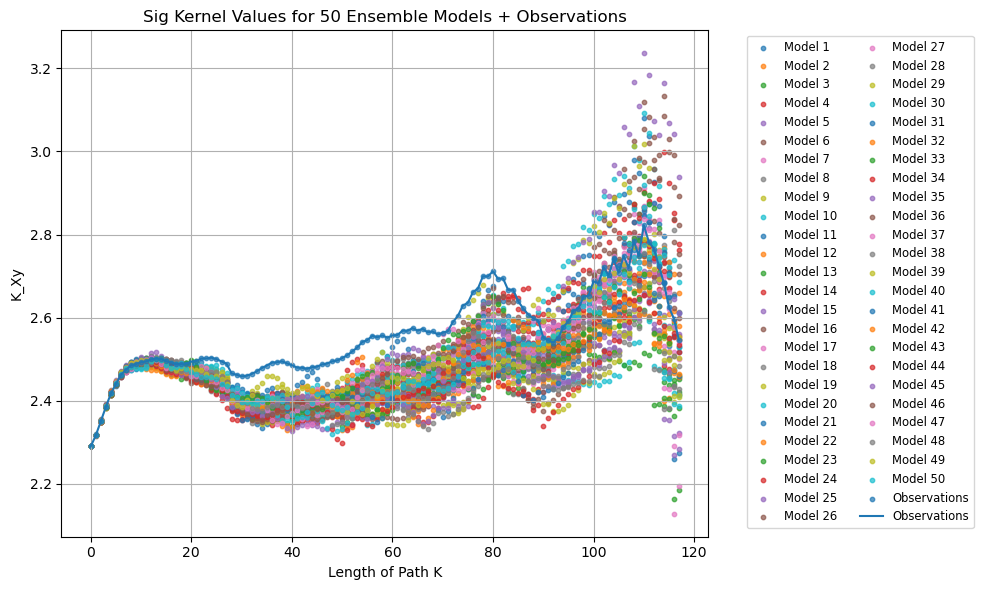

In [25]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)

for model_index in range(savedgrid.shape[1]):
    plt.scatter(
        np.arange(savedgrid.shape[0]),  # Time steps (x-axis)
        savedgrid[:, model_index],     # Model predictions (y-axis)
        label=f'Model {model_index + 1}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )
    
plt.scatter(
    np.arange(gridobs.shape[0]),  # Time steps (x-axis)
    gridobs[:],     # Model predictions (y-axis)
    label=f'Observations',
    alpha=0.7,                # Adjust transparency
    s=10                      # Size of the dots
)

plt.plot(gridobs[:], label=f'Observations', alpha=1)

# Customize the plot
plt.title('Sig Kernel Values for 50 Ensemble Models + Observations')
plt.xlabel('Length of Path K')
plt.ylabel('K_Xy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

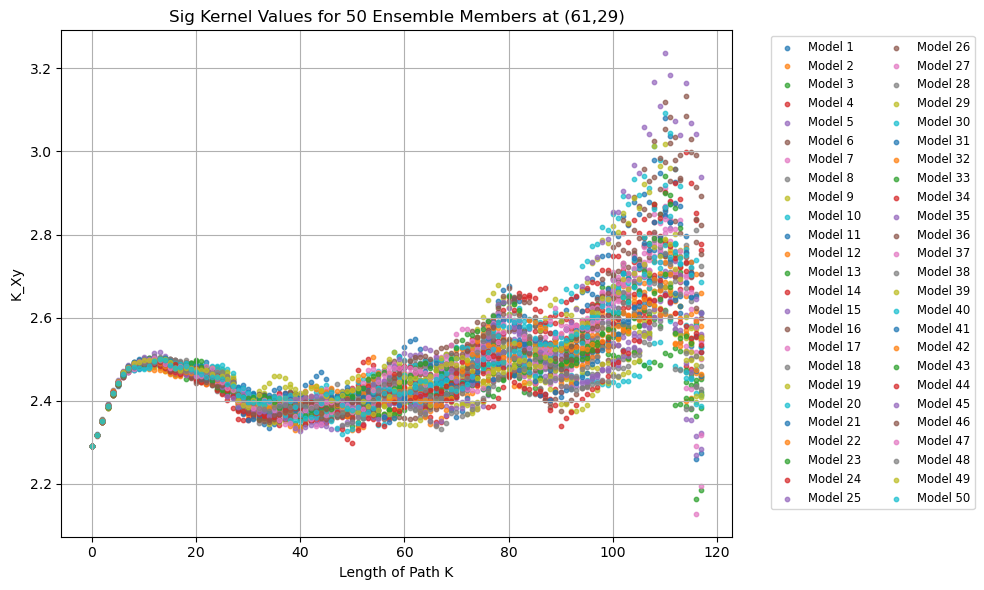

In [127]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for model_index in range(grid.shape[1]):
    plt.scatter(
        np.arange(grid.shape[0]),  # Time steps (x-axis)
        grid[:, model_index],     # Model predictions (y-axis)
        label=f'Model {model_index + 1}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )

# Customize the plot
plt.title('Sig Kernel Values for 50 Ensemble Members at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('K_Xy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

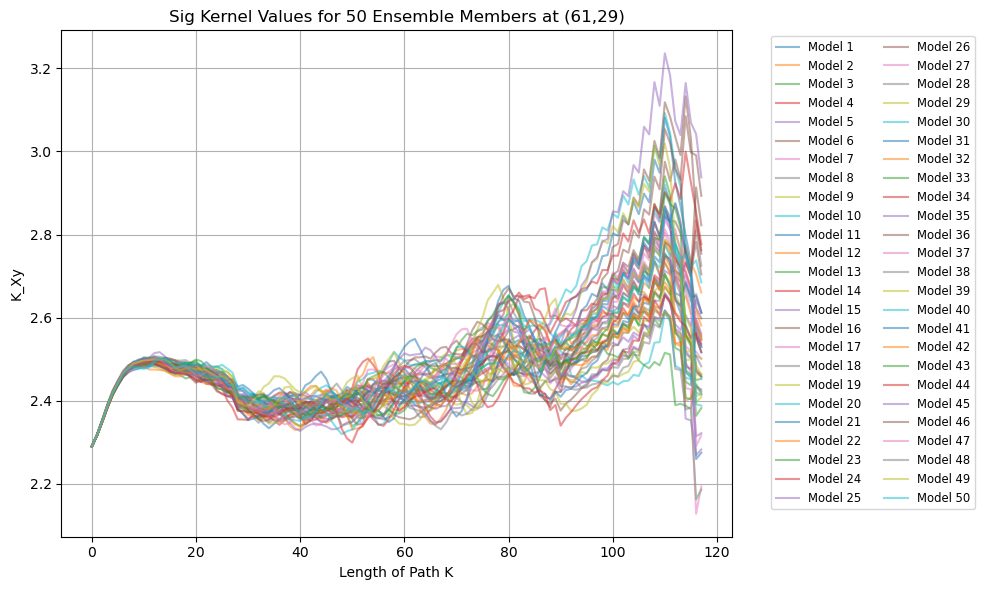

In [128]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for model_index in range(grid.shape[1]):
    plt.plot(grid[:, model_index], label=f'Model {model_index + 1}', alpha=0.5)

# Customize the plot
plt.title('Sig Kernel Values for 50 Ensemble Members at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('K_Xy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

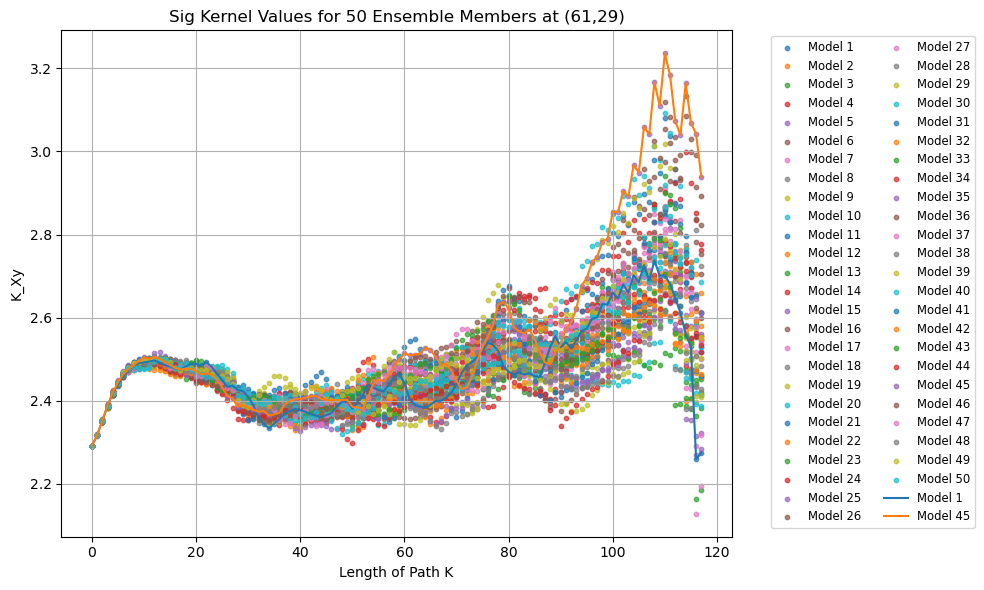

In [ ]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for model_index in range(grid.shape[1]):
    plt.scatter(
        np.arange(grid.shape[0]),  # Time steps (x-axis)
        grid[:, model_index],     # Model predictions (y-axis)
        label=f'Model {model_index + 1}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )
plt.plot(grid[:, 0], label=f'Model {0 + 1}', alpha=1)
plt.plot(grid[:, 44], label=f'Model {44 + 1}', alpha=1)

# Customize the plot
plt.title('Sig Kernel Values for 50 Ensemble Members at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('K_Xy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
quad = [forecast2vals,forecast3vals,forecast4vals,forecast5vals]
test = scaleall(observationsvals,quad)

grid = np.zeros((32,98,4))

for lat in range(32): #32
    for k in range(98): #98
        vals = pkscaleall(test[0],test[1],k+1,30,lat)
        
        for i in range(len(quad)):
            grid[lat,k,i] = vals[i]

In [41]:
grid

array([[[2.281808  , 2.28180884, 2.28187732, 2.28167375],
        [2.2842642 , 2.28421992, 2.28433316, 2.283869  ],
        [2.28740896, 2.28733424, 2.28728697, 2.28689517],
        ...,
        [2.32617515, 2.38448296, 2.27767794, 2.26774534],
        [2.28836637, 2.31476799, 2.22408719, 2.25469861],
        [2.2880031 , 2.30537622, 2.23950358, 2.261437  ]],

       [[2.28210232, 2.28212855, 2.28213543, 2.28201471],
        [2.28435869, 2.2843448 , 2.28438137, 2.28398153],
        [2.28856045, 2.28863404, 2.28857665, 2.28781703],
        ...,
        [2.35308832, 2.38608654, 2.33789292, 2.35195709],
        [2.32584272, 2.37446849, 2.30714673, 2.32803898],
        [2.33816864, 2.3754615 , 2.33240439, 2.34784142]],

       [[2.28256409, 2.28263156, 2.28261967, 2.28254995],
        [2.28667535, 2.28660633, 2.28669647, 2.28636539],
        [2.29329103, 2.29333981, 2.2935194 , 2.29284455],
        ...,
        [2.82793021, 2.83211234, 2.82668508, 2.87890186],
        [2.79103498, 2.746336

In [48]:
grid1 = (grid*weights.reshape(-1,1,1))
np.sum(grid1, axis=0)
vals = np.transpose(np.sum(grid1/32, axis=0))
vals

array([[2.28765607, 2.30003713, 2.32005582, 2.33941838, 2.35952959,
        2.3752943 , 2.38932527, 2.39990785, 2.41014277, 2.41888374,
        2.42850194, 2.43695995, 2.44624107, 2.45520288, 2.46395438,
        2.47171434, 2.4788732 , 2.48609053, 2.49317126, 2.49931031,
        2.50593551, 2.51026543, 2.51541132, 2.51916554, 2.52121863,
        2.52453921, 2.52208203, 2.52498367, 2.52232223, 2.52481898,
        2.52313007, 2.52462526, 2.52312817, 2.52495957, 2.52572505,
        2.52869125, 2.5297935 , 2.53440326, 2.53445433, 2.53958733,
        2.54007433, 2.54398274, 2.54386927, 2.54588687, 2.54078109,
        2.54064993, 2.52558164, 2.52519176, 2.51067119, 2.51018952,
        2.50059581, 2.49929599, 2.48799025, 2.48819397, 2.47534194,
        2.47465634, 2.46689679, 2.46523106, 2.46196976, 2.46031398,
        2.46159333, 2.46139758, 2.46376357, 2.46436226, 2.4663937 ,
        2.46720149, 2.46990989, 2.47001846, 2.47347576, 2.47256369,
        2.47199298, 2.47043465, 2.46901533, 2.46

In [49]:
vals.shape

(4, 98)

In [54]:
testobs = scaleall50(observationsvals,observationsvals)

gridobs4 = np.zeros((32,98))

for lat in range(32): #32
    for k in range(98): #98
        gridobs4[lat,k] = pkscaleobs(testobs[0],k+1,30,lat)

In [69]:
testing4 = gridobs4 * weights[:, np.newaxis]
testing4

array([[0.17580605, 0.17601113, 0.17623649, ..., 0.18488107, 0.18050326,
        0.17839402],
       [0.52578805, 0.52632421, 0.52727798, ..., 0.56559342, 0.56190932,
        0.55728069],
       [0.87086497, 0.8724661 , 0.87504432, ..., 1.12027334, 1.10907498,
        1.12703975],
       ...,
       [0.87289927, 0.8799483 , 0.88961174, ..., 0.96971994, 0.98068898,
        0.95594536],
       [0.52715038, 0.53133927, 0.53787538, ..., 0.56551808, 0.5729816 ,
        0.56690971],
       [0.17636558, 0.17801739, 0.18025022, ..., 0.18836976, 0.18873985,
        0.18847564]])

In [74]:
testing4 = np.transpose(np.sum(gridobs4 * weights[:, np.newaxis], axis=0)/32)
testing4.shape

(98,)

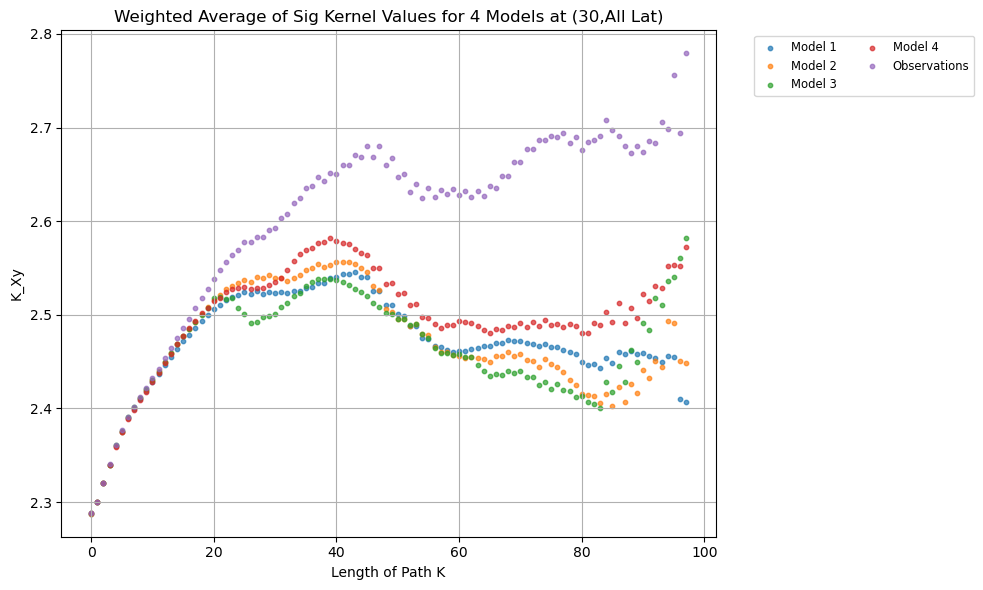

In [77]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for model_index in range(vals.shape[0]):
    plt.scatter(
        np.arange(vals.shape[1]),  # Time steps (x-axis)
        vals[model_index, :],     # Model predictions (y-axis)
        label=f'Model {model_index + 1}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )

plt.scatter(
        np.arange(testing4.shape[0]),  # Time steps (x-axis)
        testing4[:],     # Model predictions (y-axis)
        label=f'Observations',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )

#plt.plot(testing4[:], label=f'Observations', alpha=1)

# Customize the plot
plt.title('Weighted Average of Sig Kernel Values for 4 Models at (30,All Lat)')
plt.xlabel('Length of Path K')
plt.ylabel('K_Xy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

In [80]:
testfors = scaleall50(observationextended,forecast1valsextended)

#pkscalefors

gridfors = np.zeros((118,50))

for k in range(118):
    print(k)
    allfors = pkscalefors(testfors[1],k+1,61,29)
    gridfors[k,:]= allfors

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


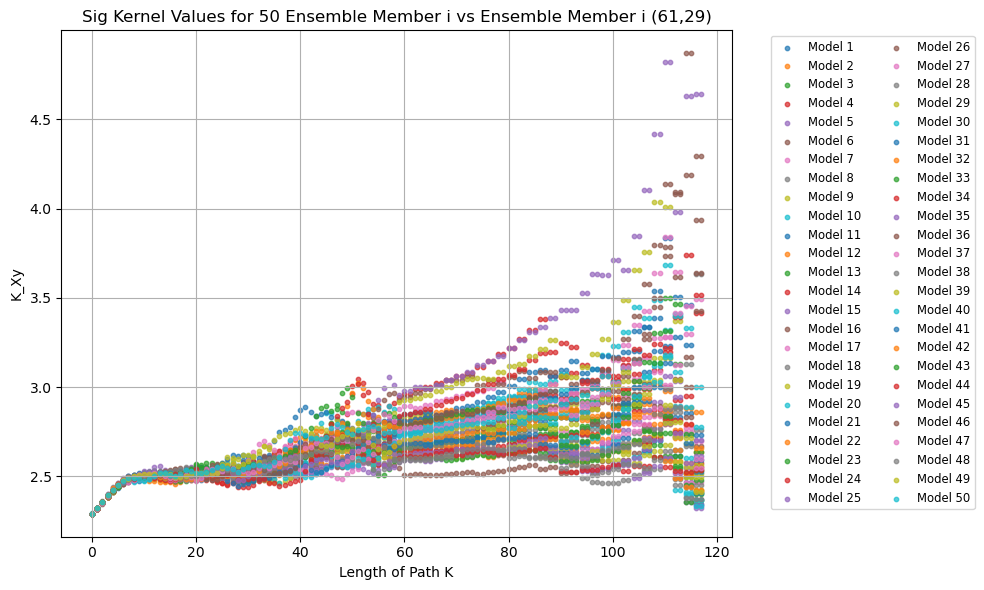

In [82]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for model_index in range(gridfors.shape[1]):
    plt.scatter(
        np.arange(gridfors.shape[0]),  # Time steps (x-axis)
        gridfors[:, model_index],     # Model predictions (y-axis)
        label=f'Model {model_index + 1}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )

# Customize the plot
plt.title('Sig Kernel Values for 50 Ensemble Member i vs Ensemble Member i (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('K_Xy')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
test50 = scaleall50(observationextended,forecast1valsextended)

grid = np.zeros((118,50))
for k in range(118):
    print(k)
    all50 = pkscaleall50(test50[0],test50[1],k+1,61,29)
    grid[k,:]= all50
#K(X,Y)

testobs = scaleall50(observationextended,forecast1valsextended)

gridobs = np.zeros(118)
for k in range(118):
    print(k)
    allobs = pkscaleobs(testobs[0],k+1,61,29)
    gridobs[k]= allobs
#K(X,Y)

testfors = scaleall50(observationextended,forecast1valsextended)

#pkscalefors

gridfors = np.zeros((118,50))

for k in range(118):
    print(k)
    allfors = pkscalefors(testfors[1],k+1,61,29)
    gridfors[k,:]= allfors



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
9

In [12]:
grid.shape

(118, 50)

In [14]:
gridobs.shape

(118,)

In [16]:
gridfors.shape

(118, 50)

In [20]:
overall = gridfors+gridobs[:, np.newaxis]-2*grid

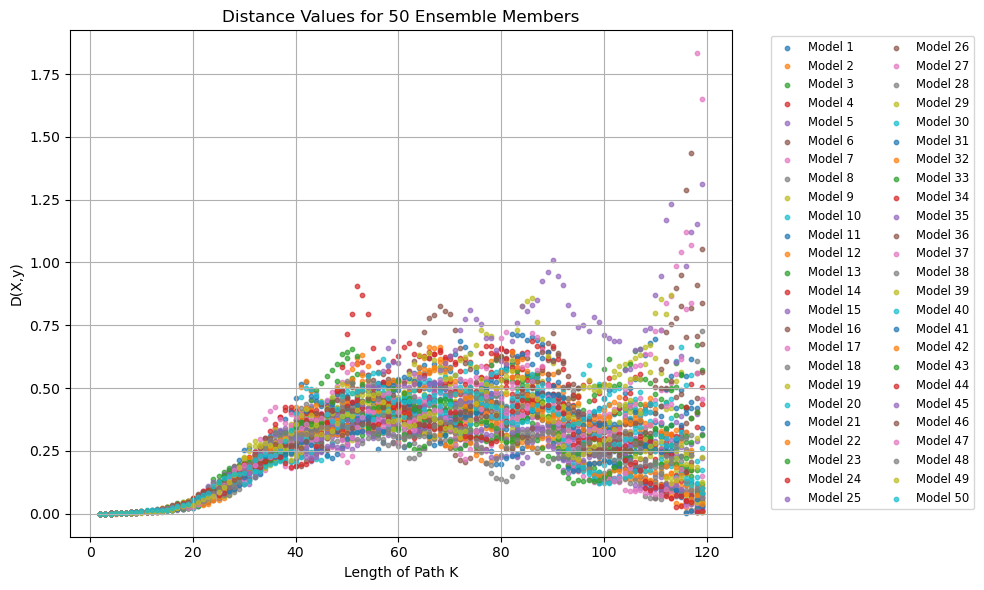

In [38]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for model_index in range(overall.shape[1]):
    plt.scatter(
        np.arange(overall.shape[0])+2,  # Time steps (x-axis)
        overall[:, model_index],     # Model predictions (y-axis)
        label=f'Model {model_index + 1}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )

# Customize the plot
plt.title('Distance Values for 50 Ensemble Members')
plt.xlabel('Length of Path K')
plt.ylabel('D(X,y)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

In [90]:
quad1 = [forecast2vals[:,0:31,:,:],forecast3vals[:,0:31,:,:],forecast4vals[:,0:31,:,:],forecast5vals[:,0:31,:,:]]
quad1 = np.stack(quad1, axis=1)

test501 = scaleall50(observationsvals,quad1)

grid1 = np.zeros((120,4))
for k in range(120):
    print(k)
    all501 = pkscaleall50(test501[0],test501[1],k+1,61,29)
    grid1[k,:]= all501
#K(X,Y)

testobs1 = scaleall50(observationsvals,quad1)

gridobs1 = np.zeros(50)
for k in range(50):
    print(k)
    allobs1 = pkscaleobs(testobs1[0],k+1,61,29)
    gridobs1[k]= allobs1
#K(X,Y)

testfors1 = scaleall50(observationsvals,quad1)

#pkscalefors

gridfors1 = np.zeros((50,4))

for k in range(50):
    print(k)
    allfors1 = pkscalefors(testfors1[1],k+1,61,29)
    gridfors1[k,:]= allfors1



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


ValueError: negative dimensions are not allowed

In [83]:
overall1 = gridfors1+gridobs1[:, np.newaxis]-2*grid1

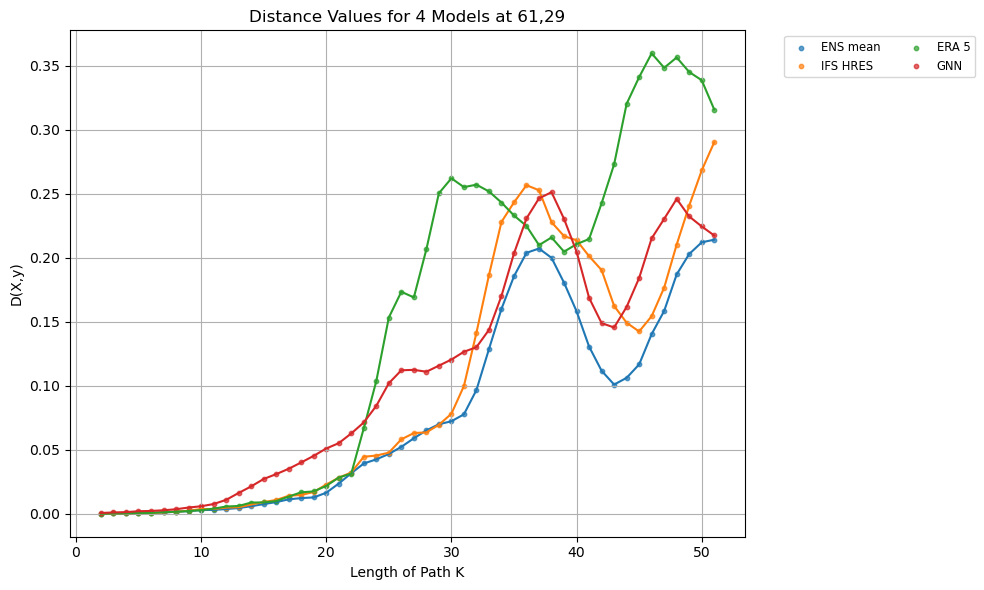

In [84]:
plt.figure(figsize=(10, 6))
Models = ["ENS mean", "IFS HRES", "ERA 5", "GNN"]
# Iterate through each of the 50 models (columns in the array)
for model_index in range(overall1.shape[1]):
    plt.scatter(
        np.arange(overall1.shape[0])+2,  # Time steps (x-axis)
        overall1[:, model_index],     # Model predictions (y-axis)
        label=f'{Models[model_index]}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )
    plt.plot(np.arange(overall1.shape[0])+2, overall1[:, model_index], alpha=1)

# Customize the plot
plt.title('Distance Values for 4 Models at 61,29')
plt.xlabel('Length of Path K')
plt.ylabel('D(X,y)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

#ENS mean
#IFSHRES
#ERA 5
#GNN

In [51]:
forecast1valsextended.shape

(60, 50, 61, 64, 32)

In [72]:
forecast2vals[:,0:31,:,:].shape

(50, 31, 64, 32)

In [62]:
quad1 = [forecast2vals,forecast3vals,forecast4vals,forecast5vals]
quad1 = np.stack(quad1, axis=1)


ValueError: all input arrays must have the same shape